In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, ranksums, linregress
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import itertools
import statannot
from statsmodels.stats.multitest import fdrcorrection
from scipy import stats

import pickle

from deeplift.visualization import viz_sequence


matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'


HEPG2_COL = 'log2FoldChange_HepG2'
K562_COL = 'log2FoldChange_K562'
H2K_COL = 'log2FoldChange_H2K'

figure_dir = 'figures'
supp_figure_dir = f'{figure_dir}/supp_figures'

TITLE_FSIZE = 12
AXIS_FSIZE = 12
TEXT_FSIZE = 10

greysBig = matplotlib.cm.get_cmap('Greys', 512)
greys_trunc_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.6, 1, 256)))

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
# blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.25, 0.8, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
# oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.25, 0.8, 256)))

from fig_utils import plot_scatter_shaded, load_ensemble_model, load_model_for_shap, plot_seq_with_motifs,\
                      cluster_name_dict, seq_to_one_hot, one_hot_to_seq,round_palette

# import logging from matplotlib
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

D2_HEPG2_COL = 'log2FoldChange_HEPG2'
D2_K562_COL = 'log2FoldChange_K562'

HEPG2_SE_COL = 'lfcSE_HEPG2'
K562_SE_COL = 'lfcSE_K562'
H2K_SE_COL = 'lfcSE_H2K'

D3_HEPG2_SE_COL = 'lfcSE_HepG2_DNA'
D3_K562_SE_COL = 'lfcSE_K562_DNA'

D1_HEPG2_SE_COL = 'lfcSE_HEPG2_DNA'
D1_K562_SE_COL = 'lfcSE_K562_DNA'

fig1_dir = f'{figure_dir}/fig1'
os.makedirs(fig1_dir,exist_ok=True)

custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)

round_palette = {
    'R0': sns.color_palette("Grays", 5)[2],
    'R1': custom_color_vec[3],
    'R2': custom_green_palette[3],
}

C:\Users\Chris\AppData\Local\Temp\ipykernel_25784\769312932.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Chris\AppData\Local\Temp\ipykernel_25784\769312932.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greysBig = matplotlib.cm.get_cmap('Greys', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_25784\769312932.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and wil

In [2]:
### Load D1, D2, and D3 data ###

# reverse complement function
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join(complement[base] for base in reversed(seq))

bc_deseqs_dir = 'bc_deseq_dfs/weighted/comb_dhs'

d2_deseq_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_df.csv')
d3_seq_df = pd.read_csv(f'{bc_deseqs_dir}/d3_seq_df.csv')
dhs_deseq_df = pd.read_csv(f'{bc_deseqs_dir}/dhs_deseq_df.csv')

d1_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d1_deseq_plus_cluster_cnts_df.csv')
d2_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_plus_cluster_cnts_df.csv')
d3_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d3_deseq_plus_cluster_cnts_df.csv')

# d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df.index
# d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df['sequence_name'].apply(lambda x: f'd1_seq_{x}')

# for any seqs in d2_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d2_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d2_deseq_df.iterrows():
    cur_enhancer = row['enhancer']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d2_deseq_df.loc[idx,'sequence_name'] = d1_seq_name
        # also rename the row in d2_deseq_df where enhancer is the reverse_complement of this enhancer
        d2_deseq_df.loc[d2_deseq_df['enhancer']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d2_deseq_plus_cluster_cnts_df['sequence_name'] = d2_deseq_df['sequence_name']
# rename log2FoldChange_HEPG2 to HEPG2_COL in d2_deseq_plus_cluster_cnts_df
d2_deseq_plus_cluster_cnts_df.rename(columns={'log2FoldChange_HEPG2': HEPG2_COL}, inplace=True)

# for any seqs in d3_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d3_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d3_seq_df.iterrows():
    cur_enhancer = row['sequence']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d3_seq_df.loc[idx,'sequence_name'] = d1_seq_name
    elif reverse_complement(cur_enhancer) in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==reverse_complement(cur_enhancer),'sequence_name'].values[0]
        d3_seq_df.loc[d3_seq_df['sequence']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d3_deseq_plus_cluster_cnts_df['sequence_name'] = d3_seq_df['sequence_name']


# d2_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/d2_deseq_data/chris_log2fc_df_clean2.csv')

d1_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d1_final_df_qthresh05_v2.csv')
d2_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d2_final_df_qthresh05_v2.csv')
d3_final_df = pd.read_csv('../designed_seqs/d3_tot_final_df_qthresh0.05.csv')

### Table S1 R1-MPRA Library Composition ###

In [24]:
d2_deseq_df['model_type'].value_counts()

model_type
boot             594
wide             245
sharpr-mpra      200
ensemble_boot    198
hand_crafted      62
df                47
Name: count, dtype: int64

In [25]:
d2_analysis_df = d2_deseq_df[d2_deseq_df['model_type']!='df'].copy()

In [28]:
d2_analysis_df.groupby('model_type')['generator'].value_counts()

model_type     generator   
boot           DENs            198
               seqprop         198
               sim_anneal      198
ensemble_boot  DENs            198
hand_crafted   motif_repeat     62
sharpr-mpra    control         200
wide           DENs            200
               seqprop          27
               sim_anneal       18
Name: count, dtype: int64

In [29]:
d3_seq_df['model_type'].unique()

array(['d2_meas', 'D2', 'shuffled', 'd1_finetuned', 'dhs64_finetuned',
       'd2_dhs', 'dhs62_finetuned', 'shuffled_nonmotif', 'ablated',
       'sabetti_ctrl'], dtype=object)

In [3]:
d3_analysis_df = d3_seq_df[~d3_seq_df['model_type'].isin(['dhs62_finetuned','dhs64_finetuned','sabetti_ctrl'])]
d3_analysis_df.groupby('model_type')['design_type'].value_counts()

model_type         design_type                 
D2                 NC                                2
ablated            ablated                         331
d1_finetuned       fsp                             258
                   fsp_clipped                     220
                   fsp_tgt                         160
                   motif_flank_opt                 128
                   fsp_minimal                     110
                   nonmotif_masked_fsp             100
                   fsp_minimal_concatemer           60
                   fsp_clipped_max1                 20
                   fsp_max1                         20
                   fsp_min1                         20
                   fsp_clipped_min1                 19
                   fsp_minimal_cross_concatemer     13
                   concatemer                        5
d2_dhs             fsp                             210
d2_meas            d2_rand_ctrl                    198
                 

### R1 Model Performance (og) ###

In [ ]:
# locate dir for original non-deseq models
model_base_dir = '../../../aws/for_aws/predictor_models'
model_dirs = [
    'boot_predictors_rf_sep',
    'wide_predictors'
]
model_names = [
    'boot',
    'wide'
]

# locate dir for original random training split


# set up code to get predictions from all these models (possibly do this as a script and send to ec2 since there will be a lot of these models? eh it's only a test set)

In [ ]:
# load og_pred_models_rvec_df.csv as rvec_df
rvec_df = pd.read_csv(f'og_pred_models_rvec_df.csv')
rvec_df['model_type'] = rvec_df['model'].apply(lambda x: 'wide' if 'wide' in x else 'ensemble' if '-' in x else 'boot')
rvec_df.head()

In [ ]:
TITLE_FSIZE = 12
AXIS_FSIZE = 12
TEXT_FSIZE = 10

# barplot of rs_h, rs_k, rs_h2k for each model type (wide, boot, ensemble)
# create df with task, model, and spearmanr from every row of rvec_df
cf_df = pd.DataFrame(columns=['task','model','Spearman r'])
for i in range(rvec_df.shape[0]):
    cf_df = pd.concat([cf_df,pd.DataFrame({'task':'HEPG2','model':rvec_df.iloc[i]['model_type'],'Spearman r':rvec_df.iloc[i]['rs_h']},index=[0])])
    cf_df = pd.concat([cf_df,pd.DataFrame({'task':'K562','model':rvec_df.iloc[i]['model_type'],'Spearman r':rvec_df.iloc[i]['rs_k']},index=[0])])
    cf_df = pd.concat([cf_df,pd.DataFrame({'task':'HEPG2-K562','model':rvec_df.iloc[i]['model_type'],'Spearman r':rvec_df.iloc[i]['rs_h2k']},index=[0])])

# add row to cf_df with task HEPG2, model 'inter-replicate', and spearmanr rs_h_sharpr_agg
cf_df = pd.concat([cf_df,pd.DataFrame({'task':'HEPG2','model':'Inter-replicate','Spearman r':0.55},index=[0])])
# add row to cf_df with task K562, model 'inter-replicate', and spearmanr 0.46
cf_df = pd.concat([cf_df,pd.DataFrame({'task':'K562','model':'Inter-replicate','Spearman r':0.46},index=[0])])
# add row to cf_df with task HEPG2-K562, model 'inter-replicate', and spearmanr 0.31
cf_df = pd.concat([cf_df,pd.DataFrame({'task':'HEPG2-K562','model':'Inter-replicate','Spearman r':0.31},index=[0])])


palette = {
    'Ensemble': sns.color_palette("Greys",n_colors=4)[0],
    'Single': sns.color_palette("Greys",n_colors=4)[1],
    'Boot': sns.color_palette("Greys",n_colors=4)[2],
    'Inter-replicate': sns.color_palette("Greys",n_colors=4)[3],
}

custom_color_vec = ['#214f4b', '#f2c078', '#cd5334', '#7ebc89', '#f4cae0']
palette = {
    'Ensemble': custom_color_vec[2],
    'Single': custom_color_vec[1],
    'Boot': custom_color_vec[0],
    'Inter-replicate': sns.color_palette("Greys",n_colors=4)[3],
}

# rename cf_df['model_type] to have capital first letter
cf_df['model'] = cf_df['model'].apply(lambda x: x.capitalize())
# change Wide to Single in model type column
cf_df['model'] = cf_df['model'].apply(lambda x: 'Single' if x == 'Wide' else x)


plt.figure(figsize=(4.25,2.5))
# plt.figure(figsize=(4.5*.9,2.5*.9))
# hue_order = ['Ensemble','Wide','Boot']
hue_order = ['Inter-replicate','Ensemble','Single','Boot']
ax = sns.barplot(x = cf_df['task'], y = cf_df['Spearman r'], hue = cf_df['model'],
                 hue_order=hue_order,palette=palette,errorbar='sd',zorder=20,gap=0.1)
# label xticks log2(HEPG2), log2(K562), log2(HEPG2/K562)
# get xtick locations
xtick_locs = ax.get_xticks()
ax.set_xticklabels(['log2(HEPG2)','log2(K562)','log2(HEPG2/K562)'])
# ax.set(xlabel=' ',ylabel='Spearman R',title="Comparing predictor performance")
ax.set(xlabel=' ',ylabel='Spearman R')
# set axis fontsize
ax.yaxis.label.set_fontsize(AXIS_FSIZE)
# set xtick fontsize
ax.tick_params(axis='x', labelsize=TEXT_FSIZE)
# set ylim to 0.1 to 0.5
ax.set_ylim(0.15,0.6)


# set legend outside of plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# move legend to below plot
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=2,frameon=False,fontsize=TEXT_FSIZE)
# despine
sns.despine()
# add horizontal grid lines
# ax.yaxis.grid(True,zorder=-1,color='gray',linestyle='--',linewidth=0.5,alpha=0.5)

# # draw a horizontal dashed line only for the first xtick at 0.55
# ax.axhline(y=0.55, xmin=0.01, xmax=0.3, color='k', linestyle='--',linewidth=1)
# # draw a horizontal dashed line only for the second xtick at 0.46
# ax.axhline(y=0.46, xmin=0.35, xmax=0.65, color='k', linestyle='--',linewidth=1)
# # draw a horizontal dashed line only for the third xtick at 0.31
# ax.axhline(y=0.31, xmin=0.69, xmax=0.99, color='k', linestyle='--',linewidth=1)

# # save figure
plt.savefig('figure_dir/general_exam_figs/fig1_predictor_r_barplots_interrep.png',transparent=True,bbox_inches='tight',dpi=600)

### Edit Distance plot for R2 ###

In [9]:
d3_seq_df['design_type'].value_counts()

design_type
fsp                             778
fsp_clipped                     437
ablated                         331
fsp_tgt                         319
fsp_minimal                     220
nonmotif_masked_fsp             199
d2_rand_ctrl                    198
motif_flank_opt                 128
fsp_minimal_concatemer          120
shuffled_nonmotif                49
fsp_max1                         40
fsp_min1                         40
fsp_clipped_max1                 40
fsp_clipped_min1                 39
fsp_minimal_cross_concatemer     26
d2_top_ctrl                      10
concatemer                        5
NC                                4
sabetti_ctrl                      4
Name: count, dtype: int64

In [3]:
# Ugh I have to do this for both R2 vs R1, and R2 vs R0
# also I should probably regenerate the edit distance plots for R1 subsetting only the designed seqs from R1

r0_analysis_df = d1_deseq_plus_cluster_cnts_df.copy()

r1_analysis_df = d2_deseq_df[~d2_deseq_df['model_type'].isin(['sharpr-mpra','df'])].copy()

d3_model_types = ['d1_finetuned','d2_dhs']
d3_design_types = ['fsp','fsp_clipped']
# this is excluding target designs, 
r2_analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types)) & (d3_seq_df['design_type'].isin(d3_design_types))].copy()

In [6]:
# load d1 data

x_tot_r0 = np.concatenate(r0_analysis_df['seq'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)
x_tot_r1 = np.concatenate(r1_analysis_df['enhancer'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)
x_tot_r2 = np.concatenate(r2_analysis_df['sequence'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)

r0_seqs = r0_analysis_df['seq'].values
r1_seqs = r1_analysis_df['enhancer'].values
r2_seqs = r2_analysis_df['sequence'].values

load_rand_seqs = True

if load_rand_seqs:
    with open(f'SI/edit_distances/x_rand_r0.pkl','rb') as f:
        x_rand_r0 = pickle.load(f)
    with open(f'SI/edit_distances/x_rand_r1.pkl','rb') as f:
        x_rand_r1 = pickle.load(f)
    with open(f'SI/edit_distances/x_rand_r2.pkl','rb') as f:
        x_rand_r2 = pickle.load(f)
else:

    bg_freq_r0 = np.sum(np.sum(x_tot_r0,axis=0),axis=0)/x_tot_r0.shape[0]/x_tot_r0.shape[1]
    bg_freq_r1 = np.sum(np.sum(x_tot_r1,axis=0),axis=0)/x_tot_r1.shape[0]/x_tot_r1.shape[1]
    bg_freq_r2 = np.sum(np.sum(x_tot_r2,axis=0),axis=0)/x_tot_r2.shape[0]/x_tot_r2.shape[1]
    print(bg_freq_r0)
    print(bg_freq_r1)
    print(bg_freq_r2)
    # A, C, G, T

    # sample 1000 random sequences of 145 bp length from the background distribution
    # and calculate the mean and std of the background distribution
    n = 1000
    seq_len = 145

    bg_seqs = np.random.choice(4, size=(n, seq_len), p=bg_freq_r0)
    bg_seqs = np.eye(4)[bg_seqs]
    bg_seqs = bg_seqs.reshape(n,seq_len,4)
    print(bg_seqs.shape)
    x_rand_r0 = [one_hot_to_seq(seq) for seq in bg_seqs]

    bg_seqs = np.random.choice(4, size=(n, seq_len), p=bg_freq_r1)
    bg_seqs = np.eye(4)[bg_seqs]
    bg_seqs = bg_seqs.reshape(n,seq_len,4)
    print(bg_seqs.shape)
    x_rand_r1 = [one_hot_to_seq(seq) for seq in bg_seqs]

    bg_seqs = np.random.choice(4, size=(n, seq_len), p=bg_freq_r2)
    bg_seqs = np.eye(4)[bg_seqs]
    bg_seqs = bg_seqs.reshape(n,seq_len,4)
    print(bg_seqs.shape)
    x_rand_r2 = [one_hot_to_seq(seq) for seq in bg_seqs]

    # save the random sequences
    with open(f'SI/x_rand_r0.pkl','wb') as f:
        pickle.dump(x_rand_r0,f)
    with open(f'SI/x_rand_r1.pkl','wb') as f:
        pickle.dump(x_rand_r1,f)
    with open(f'SI/x_rand_r2.pkl','wb') as f:
        pickle.dump(x_rand_r2,f)

# calculate pairwise Levenshtein distances
from Levenshtein import distance

load_internal_rand_dist = True

if load_internal_rand_dist:
    with open(f'SI/edit_distances/rand_internal_dist_r0.pkl','rb') as f:
        rand_dist_r0 = pickle.load(f)
    with open(f'SI/edit_distances/rand_internal_dist_r1.pkl','rb') as f:
        rand_dist_r1 = pickle.load(f)
    with open(f'SI/edit_distances/rand_internal_dist_r2.pkl','rb') as f:
        rand_dist_r2 = pickle.load(f)
else:
    for idx,x_rand in enumerate([x_rand_r0, x_rand_r1, x_rand_r2]):
        rand_dist = np.array([distance(x_rand[i], x_rand[j]) for i, j in itertools.combinations(range(len(x_rand)), 2)])
        rand_dist = rand_dist / 145.
        # save rand_dist
        with open(f'SI/edit_distances/rand_internal_dist_r{idx}.pkl','wb') as f:
            pickle.dump(rand_dist,f)
        print(np.mean(rand_dist))
        print(np.median(rand_dist))

# calculate smallest pairwise Levenshtein distance between each rando sequence and all the sequences in d1
    
# R1 rand vs R0

comp_seqs = r0_seqs.copy()
rand_dist = np.array([np.min([distance(x_rand_r1[i], comp_seqs[j]) for j in range(len(comp_seqs))]) for i in range(len(x_rand))])
rand_dist = rand_dist / 145.
# save rand_dist
with open(f'SI/edit_distances/rand_dist_rand_r1_vs_r0.pkl','wb') as f:
    pickle.dump(rand_dist,f)
print(np.mean(rand_dist))
print(np.median(rand_dist))

# R2 rand vs R0

rand_dist = np.array([np.min([distance(x_rand_r2[i], comp_seqs[j]) for j in range(len(comp_seqs))]) for i in range(len(x_rand))])
rand_dist = rand_dist / 145.
# save rand_dist
with open(f'SI/edit_distances/rand_dist_rand_r2_vs_r0.pkl','wb') as f:
    pickle.dump(rand_dist,f)
print(np.mean(rand_dist))
print(np.median(rand_dist))

# R2 rand vs R1

comp_seqs = r1_seqs.copy()
rand_dist = np.array([np.min([distance(x_rand_r2[i], comp_seqs[j]) for j in range(len(comp_seqs))]) for i in range(len(x_rand))])
rand_dist = rand_dist / 145.
# save rand_dist
with open(f'SI/edit_distances/rand_dist_rand_r2_vs_r1.pkl','wb') as f:
    pickle.dump(rand_dist,f)
print(np.mean(rand_dist))
print(np.median(rand_dist))

0.547129501915709
0.5448275862068965
0.5477817679748714
0.5448275862068965
0.5486852645749198
0.5517241379310345
0.45651034482758623
0.45517241379310347
0.4585586206896552
0.46206896551724136
0.4790551724137931
0.4827586206896552


In [31]:
# okay now I need to estimate the internal library diversity of the designed sequences
import editdistance
from itertools import combinations
def _get_min_distances(df,seq_col='seq'):
    n_seqs = df.shape[0]
    min_distances = np.zeros(n_seqs)
    
    
    for i in range(n_seqs):
        
        distances = np.zeros(n_seqs)
        for j in range(n_seqs):
            distances[j] = editdistance.eval(df[seq_col].values[i],df[seq_col].values[j])
            
            
        min_distances[i] = np.min(distances[distances != 0]) / 145
        
    return min_distances

d2_vs_d2_min_dist = _get_min_distances(r1_analysis_df,seq_col='enhancer')
# save as npy
np.save(f'SI/edit_distances/d2_vs_d2_min_dist.npy',d2_vs_d2_min_dist)

d3_vs_d3_min_dist = _get_min_distances(r2_analysis_df,seq_col='sequence')
# save as npy
np.save(f'SI/edit_distances/d3_vs_d3_min_dist.npy',d3_vs_d3_min_dist)

In [32]:
# # now I have to calculate the R2 to R1 distance, and the R2 to R0 distance

# # start with R2 to R1

# n_r2_seqs = r2_analysis_df.shape[0]
# n_r1_seqs = r1_analysis_df.shape[0]
# r2_seqs = r2_analysis_df['sequence'].values
# r1_seqs = r1_analysis_df['enhancer'].values

# min_distances = np.zeros(n_r2_seqs)
# for i in range(n_r2_seqs):
#     distances = np.zeros(n_r1_seqs)
#     for j in range(n_r1_seqs):
#         distances[j] = editdistance.eval(r2_seqs[i],r0_seqs[j])
#     min_distances[i] = np.min(distances) / 145

# np.save(f'SI/edit_distances/r2_vs_r1_min_dist.npy',min_distances)

# # now R2 to R0

# n_r0_seqs = r0_analysis_df.shape[0]
# r0_seqs = r0_analysis_df['seq'].values

# min_distances = np.zeros(n_r2_seqs)
# for i in range(n_r2_seqs):
#     distances = np.zeros(n_r0_seqs)
#     for j in range(n_r0_seqs):
#         distances[j] = editdistance.eval(r2_seqs[i],r0_seqs[j])
#     min_distances[i] = np.min(distances) / 145

# np.save(f'SI/edit_distances/r2_vs_r0_min_dist.npy',min_distances)

# # finally, redo R1 vs R0

# min_distances = np.zeros(n_r1_seqs)
# for i in range(n_r1_seqs):
#     distances = np.zeros(n_r0_seqs)
#     for j in range(n_r0_seqs):
#         distances[j] = editdistance.eval(r1_seqs[i],r0_seqs[j])
#     min_distances[i] = np.min(distances) / 145

# np.save(f'SI/edit_distances/r1_vs_r0_min_dist.npy',min_distances)

In [4]:
# d1_vs_d1_min_dist = np.load(f'SI/edit_distances/d1_vs_d1_min_dist.npy')
# d2_vs_d2_min_dist = np.load(f'SI/edit_distances/d2_vs_d2_min_dist.npy')
# d2_vs_d1_min_dist = np.load(f'SI/edit_distances/d2_vs_d1_min_dist.npy')

# internal library diversity
r0_vs_r0_min_dist = np.load(f'SI/edit_distances/d1_vs_d1_min_dist.npy')
r1_vs_r1_min_dist = np.load(f'SI/edit_distances/d2_vs_d2_min_dist.npy')
r2_vs_r2_min_dist = np.load(f'SI/edit_distances/d3_vs_d3_min_dist.npy')

# difference from previous rounds
r2_vs_r1_min_dist = np.load(f'SI/edit_distances/r2_vs_r1_min_dist.npy')
r2_vs_r0_min_dist = np.load(f'SI/edit_distances/r2_vs_r0_min_dist.npy')
r1_vs_r0_min_dist = np.load(f'SI/edit_distances/r1_vs_r0_min_dist.npy')

# load the random library internal dversity from pkl files
with open(f'SI/edit_distances/rand_internal_dist_r0.pkl','rb') as f:
    rand_dist_r0 = pickle.load(f)
with open(f'SI/edit_distances/rand_internal_dist_r1.pkl','rb') as f:
    rand_dist_r1 = pickle.load(f)
with open(f'SI/edit_distances/rand_internal_dist_r2.pkl','rb') as f:
    rand_dist_r2 = pickle.load(f)

# load random vs r0
with open(f'SI/edit_distances/rand_dist_rand_r1_vs_r0.pkl','rb') as f:
    rand_dist_rand_r1_vs_r0 = pickle.load(f)
with open(f'SI/edit_distances/rand_dist_rand_r2_vs_r0.pkl','rb') as f:
    rand_dist_rand_r2_vs_r0 = pickle.load(f)
with open(f'SI/edit_distances/rand_dist_rand_r2_vs_r1.pkl','rb') as f:
    rand_dist_rand_r2_vs_r1 = pickle.load(f)

# dist_avg_vs_avg_mean = 0.5479707155431294
# dist_avg_vs_avg_median = 0.5517241379310345

# dist_avg_vs_d1_mean = 0.45556551724137934
# dist_avg_vs_d1_median = 0.45517241379310347

C:\Users\Chris\AppData\Local\Temp\ipykernel_27220\3322087489.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['{:.2f}'.format(x) for x in xticks])


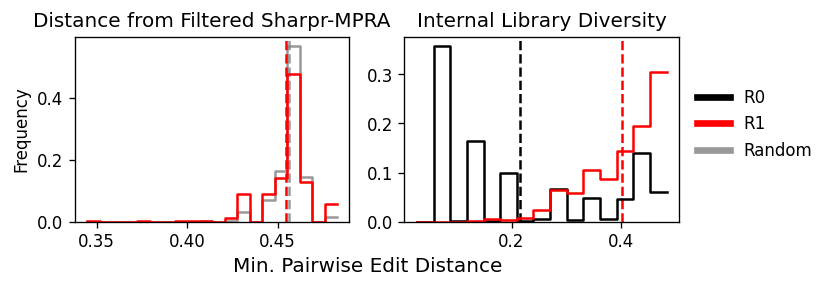

In [39]:
# plot the above 2 cells as a vertical subplot with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6.5,2))

# histogram of min pairwise edit distance
# import Line2D
from matplotlib.lines import Line2D


n_bins = 20
sns.histplot(x=r1_vs_r0_min_dist,stat='probability',bins=n_bins,color='red',fill=False,element='step',ax=ax1)
# get bins used in p
bins = np.histogram_bin_edges(r1_vs_r0_min_dist,bins=n_bins)
sns.histplot(x=rand_dist_rand_r1_vs_r0,stat='probability',bins=bins,color='gray',alpha=0.8,fill=False,element='step',zorder=0,ax=ax1)
ax1.set_ylabel('Frequency')
# ax1.set_xlabel('Min. Pairwise Edit Distance')
ax1.set_title('Distance from Filtered Sharpr-MPRA')
# plt.legend(['Designed','Random'],loc='upper left',frameon=False)

# plot horizontal line at mean of both distributions
ax1.axvline(x=np.mean(r1_vs_r0_min_dist), color='red', linestyle='--',zorder=0)
ax1.axvline(x=np.mean(rand_dist_rand_r1_vs_r0), color='gray', linestyle='--',zorder=0,alpha=0.8)

# get xticks from ax1
xticks = ax1.get_xticks()

# change all labels to 2 decimal points for ax1
ax1.set_xticklabels(['{:.2f}'.format(x) for x in xticks])


# # hide every other xtick
# for i, label in enumerate(ax1.get_xticklabels()):
#     if i % 2 == 0:
#         label.set_visible(False)

#################################################################

n_bins = 15
# get bins used in p
bins = np.histogram_bin_edges(r0_vs_r0_min_dist,bins=n_bins)
sns.histplot(x=r0_vs_r0_min_dist,stat='probability',bins=bins,color='k',fill=False,element='step',ax=ax2)
sns.histplot(x=r1_vs_r1_min_dist,stat='probability',bins=bins,color='red',fill=False,element='step',ax=ax2)
# p = sns.histplot(y=rand_vs_rand_dist,stat='probability',bins=bins,color='gray',alpha=0.5,fill=False,element='step',zorder=0)
ax2.set_ylabel('')
# ax2.set_xlabel('Min. Pairwise Edit Distance')
ax2.set_title('Internal Library Diversity')
# plt.legend(['Sharpr','Designed'],loc='center',frameon=False)

# set overall figure xlabel to 'Min. Pairwise Edit Distance'
fig.text(0.5, -0.1, 'Min. Pairwise Edit Distance', ha='center',fontsize=12)

# make a legend with a black line for Sharpr and a red line for Designed and a gray line for Random
lines = [Line2D([0], [0], color='k', lw=4),
            Line2D([0], [0], color='red', lw=4),
            Line2D([0], [0], color='gray', lw=4,alpha=0.8)]
labels = ['R0','R1','Random']
# put legend outside of plot to the right
# plt.legend(lines, labels,loc='upper left',frameon=False)
# put legend outside to right of plot
plt.legend(lines, labels,loc='upper center',bbox_to_anchor=(1.275, 0.8),frameon=False)

# plot horizontal line at mean of both distributions
ax2.axvline(x=np.mean(r0_vs_r0_min_dist), color='k', linestyle='--',zorder=0)
ax2.axvline(x=np.mean(r1_vs_r1_min_dist), color='red', linestyle='--',zorder=0)
# plt.axhline(y=np.mean(rand_vs_rand_dist), color='gray', linestyle='--',zorder=0,alpha=0.5)

# increase space between subplots
plt.subplots_adjust(hspace=0.8)


# save figure
plt.savefig(f'{supp_figure_dir}/S1/S1D_edit_distance.png',dpi=500,bbox_inches='tight')

C:\Users\Chris\AppData\Local\Temp\ipykernel_30164\1898114588.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['{:.2f}'.format(x) for x in xticks])


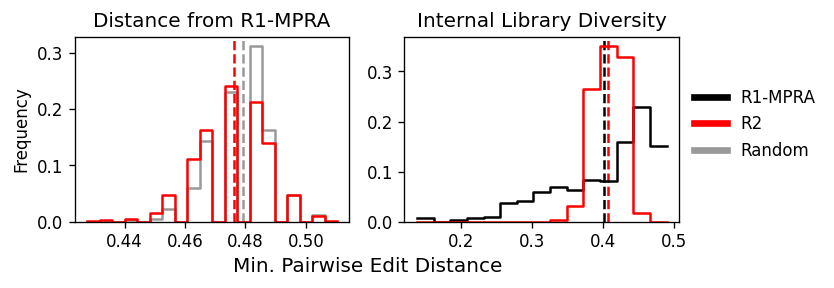

In [6]:
# okay, for the r2 version of this figure, I can do the same thing but replace r0 with r1, maybe I don't really care about r2 to r0 for this analysis

# plot the above 2 cells as a vertical subplot with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6.5,2))

# histogram of min pairwise edit distance
# import Line2D
from matplotlib.lines import Line2D


n_bins = 20
sns.histplot(x=r2_vs_r1_min_dist,stat='probability',bins=n_bins,color='red',fill=False,element='step',ax=ax1)
# get bins used in p
bins = np.histogram_bin_edges(r2_vs_r1_min_dist,bins=n_bins)
sns.histplot(x=rand_dist_rand_r2_vs_r1,stat='probability',bins=bins,color='gray',alpha=0.8,fill=False,element='step',zorder=0,ax=ax1)
ax1.set_ylabel('Frequency')
# ax1.set_xlabel('Min. Pairwise Edit Distance')
ax1.set_title('Distance from R1-MPRA')
# plt.legend(['Designed','Random'],loc='upper left',frameon=False)

# plot horizontal line at mean of both distributions
ax1.axvline(x=np.mean(r2_vs_r1_min_dist), color='red', linestyle='--',zorder=0)
ax1.axvline(x=np.mean(rand_dist_rand_r2_vs_r1), color='gray', linestyle='--',zorder=0,alpha=0.8)

# get xticks from ax1
xticks = ax1.get_xticks()

# change all labels to 2 decimal points for ax1
ax1.set_xticklabels(['{:.2f}'.format(x) for x in xticks])


# # hide every other xtick
# for i, label in enumerate(ax1.get_xticklabels()):
#     if i % 2 == 0:
#         label.set_visible(False)

#################################################################

n_bins = 15
# get bins used in p
bins = np.histogram_bin_edges(r1_vs_r1_min_dist,bins=n_bins)
sns.histplot(x=r1_vs_r1_min_dist,stat='probability',bins=bins,color='k',fill=False,element='step',ax=ax2)
sns.histplot(x=r2_vs_r2_min_dist,stat='probability',bins=bins,color='red',fill=False,element='step',ax=ax2)
# p = sns.histplot(y=rand_vs_rand_dist,stat='probability',bins=bins,color='gray',alpha=0.5,fill=False,element='step',zorder=0)
ax2.set_ylabel('')
# ax2.set_xlabel('Min. Pairwise Edit Distance')
ax2.set_title('Internal Library Diversity')
# plt.legend(['Sharpr','Designed'],loc='center',frameon=False)

# set overall figure xlabel to 'Min. Pairwise Edit Distance'
fig.text(0.5, -0.1, 'Min. Pairwise Edit Distance', ha='center',fontsize=12)

# make a legend with a black line for Sharpr and a red line for Designed and a gray line for Random
lines = [Line2D([0], [0], color='k', lw=4),
            Line2D([0], [0], color='red', lw=4),
            Line2D([0], [0], color='gray', lw=4,alpha=0.8)]
labels = ['R1-MPRA','R2','Random']
# put legend outside of plot to the right
# plt.legend(lines, labels,loc='upper left',frameon=False)
# put legend outside to right of plot
plt.legend(lines, labels,loc='upper center',bbox_to_anchor=(1.275, 0.8),frameon=False)

# plot horizontal line at mean of both distributions
ax2.axvline(x=np.mean(r1_vs_r1_min_dist), color='k', linestyle='--',zorder=0)
ax2.axvline(x=np.mean(r2_vs_r2_min_dist), color='red', linestyle='--',zorder=0)
# plt.axhline(y=np.mean(rand_vs_rand_dist), color='gray', linestyle='--',zorder=0,alpha=0.5)

# increase space between subplots
plt.subplots_adjust(hspace=0.8)

# save figure
plt.savefig(f'{supp_figure_dir}/S3/S3B_edit_distance.png',dpi=500,bbox_inches='tight')

### R2 Model Performance ###

In [17]:
TEXT_FSIZE = 12

C:\Users\Chris\AppData\Local\Temp\ipykernel_29528\2221206265.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spearman_df['model'].replace({'d1':'M0','d1_finetuned':'M0+1','d2_dhs/hp_0':'M1'},inplace=True)
C:\Users\Chris\AppData\Local\Temp\ipykernel_29528\2221206265.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


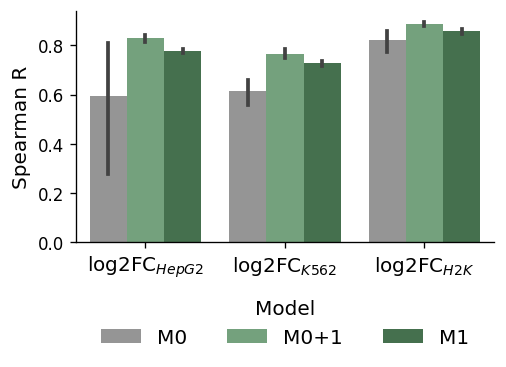

In [20]:
model_types = ['d1',
               'd1_finetuned',
               'd2_dhs/hp_0',
               ]

data_dir = '../../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0'

results_basenames = {
    'd1': 'd1_wide_cf',
    'd1_finetuned': 'cf10_d1_t0_finetuned',
    'd2_dhs/hp_0': 'cf10_d2_dw_t0'
}

spearman_df = pd.DataFrame()
for model_type in model_types:
    df = pd.read_csv(f'{data_dir}/{model_type}/{results_basenames[model_type]}_d2_dhs_test_results_spearmanr.txt',header=None)
    df.columns = ['hepg2_d2','k562_d2','h2k_d2','hepg2_dhs','k562_dhs','h2k_dhs']
    df['model'] = model_type
    # remove last row - this is the ensemble performance
    df = df.iloc[:-1,:]
    spearman_df = pd.concat([spearman_df,df])

# barplot of pearson correlations grouped by model
spearman_df = spearman_df.melt(id_vars=['model'],value_vars=['hepg2_d2','k562_d2','h2k_d2','hepg2_dhs','k562_dhs','h2k_dhs'])
spearman_df.columns = ['model','cell_line','pearsonr']

# rename columns: 'd1' to 'R0', 'd1_finetuned' to 'R0+R1', 'd2_dhs/hp_0' to 'R1' -> this is for plotting purposes
# spearman_df['model'].replace({'d1':'R0','d1_finetuned':'R0+R1','d2_dhs/hp_0':'R1'},inplace=True)
spearman_df['model'].replace({'d1':'M0','d1_finetuned':'M0+1','d2_dhs/hp_0':'M1'},inplace=True)

custom_color_vec = ["#f2f3ae","#edd382","#fc9e4f","#f4442e","#020122"]

# palette = {
#     'R0': custom_color_vec[0],
#     'R0+R1': custom_color_vec[2],
#     'R1': custom_color_vec[3],
# }

custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)
palette = {
    'M0': sns.color_palette("Grays", 5)[2],
    'R1-D': custom_green_palette[1],
    'M0+1': custom_green_palette[2],
    'M1': custom_green_palette[3],
}

fig, ax = plt.subplots(figsize=(4.5,2.5))
order = ['hepg2_d2','k562_d2','h2k_d2']
xtick_labels = ['log2FC$_{HepG2}$','log2FC$_{K562}$','log2FC$_{H2K}$']
ax = sns.barplot(x='cell_line',y='pearsonr',hue='model',data=spearman_df,order=order,palette=palette)
ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
ax.set_xlabel('')
ax.set_ylabel('Spearman R',fontsize=TEXT_FSIZE)
ax.set_title('')

# despine
sns.despine()

# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend_labels = ['M0','M0+1','M1']
legend_title = 'Model'
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=3,frameon=False,fontsize=TEXT_FSIZE,title=legend_title,title_fontsize=TEXT_FSIZE)
# move x axis label down
ax.xaxis.labelpad = 10
# plt.tight_layout()

# save
plt.savefig(f'{supp_figure_dir}/S2/finetuned_model_prediction_barplot.png',dpi=600,bbox_inches='tight')

### Replicate correlation for R2 ###

In [7]:
d1_deseq_plus_cluster_cnts_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d1_deseq_plus_cluster_cnts_df_qthresh05_v2_plus_cell_type.csv')
# hepg2_r2 = d1_deseq_plus_cluster_cnts_df[['hepg2_minp_rep1_count', 'hepg2_minp_rep2_count']].corr().values[0, 1]
hepg2_r2 = spearmanr(d1_deseq_plus_cluster_cnts_df['hepg2_minp_rep1_count'],d1_deseq_plus_cluster_cnts_df['hepg2_minp_rep2_count'])[0]
# hepg2_r2 = spearmanr(d1_deseq_plus_cluster_cnts_df[['hepg2_minp_rep1_count', 'hepg2_minp_rep2_count']])[0]
print('HepG2 R2:', hepg2_r2)
# k562_r2 = d1_deseq_plus_cluster_cnts_df[['k562_minp_rep1_count', 'k562_minp_rep2_count']].corr().values[0, 1]
k562_r2 = spearmanr(d1_deseq_plus_cluster_cnts_df[['k562_minp_rep1_count', 'k562_minp_rep2_count']])[0]
print('K562 R2:', k562_r2)

# average spearman r
avg_r2 = (hepg2_r2 + k562_r2) / 2
print('Avg R2:', avg_r2)

HepG2 R2: 0.6683164253664757
K562 R2: 0.5474812520103098
Avg R2: 0.6078988386883928


In [8]:
raw_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/d2_deseq_data/chris_log2fc_df_clean2.csv')

HEPG2_REP1_COL = 'cnt_hepg2_r3'
HEPG2_REP2_COL = 'cnt_hepg2_r4'
K562_REP1_COL = 'cnt_k562_r1'
K562_REP2_COL = 'cnt_k562_r2'

hepg2_r2 = spearmanr(raw_deseq_df[HEPG2_REP1_COL], raw_deseq_df[HEPG2_REP2_COL])[0]
print('HepG2 R2:', hepg2_r2)
k562_r2 = spearmanr(raw_deseq_df[K562_REP1_COL], raw_deseq_df[K562_REP2_COL])[0]
print('K562 R2:', k562_r2)
avg_r2 = (hepg2_r2 + k562_r2) / 2
print('Avg R2:', avg_r2)

HepG2 R2: 0.9983484326434168
K562 R2: 0.985281548056567
Avg R2: 0.9918149903499919


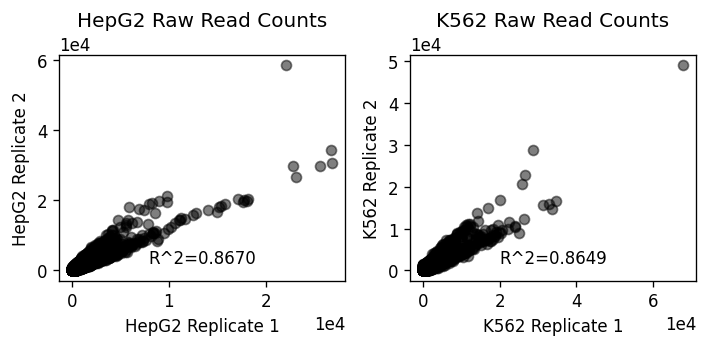

In [8]:
# R0 version

# R1 version

raw_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d1_deseq_plus_cluster_cnts_df_qthresh05_v2_plus_cell_type.csv')

HEPG2_REP1_COL = 'hepg2_minp_rep1_count'
HEPG2_REP2_COL = 'hepg2_minp_rep2_count'
K562_REP1_COL = 'k562_minp_rep1_count'
K562_REP2_COL = 'k562_minp_rep2_count'

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6,3))

# plot HEPG2 REP1 vs REP2 scatterplot
ax1.scatter(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL],color='black',alpha=0.5)
ax1.set_xlabel('HepG2 Replicate 1')
ax1.set_ylabel('HepG2 Replicate 2')
ax1.set_title('HepG2 Raw Read Counts')
# add text annotation of R^2
r2 = np.corrcoef(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL])[0,1]**2
ax1.text(0.5, 0.1, f'R^2={r2:.4f}', ha='center', va='center', transform=ax1.transAxes)

# plot K562 REP1 vs REP2 scatterplot
ax2.scatter(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL],color='black',alpha=0.5)
ax2.set_xlabel('K562 Replicate 1')
ax2.set_ylabel('K562 Replicate 2')
ax2.set_title('K562 Raw Read Counts')
# add text annotation of R^2
r2 = np.corrcoef(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL])[0,1]**2
ax2.text(0.5, 0.1, f'R^2={r2:.4f}', ha='center', va='center', transform=ax2.transAxes)

ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


# set tight
plt.tight_layout()

# save figure
# plt.savefig(f'{supp_figure_dir}/S1/S1x_raw_read_counts_rep_correlation.png',dpi=500,bbox_inches='tight')

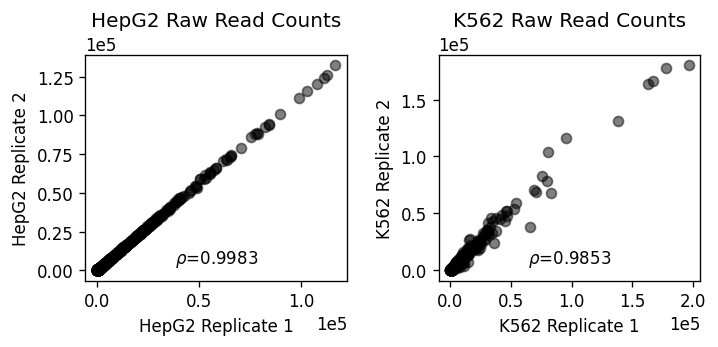

In [11]:
# R1 version

raw_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/d2_deseq_data/chris_log2fc_df_clean2.csv')

HEPG2_REP1_COL = 'cnt_hepg2_r3'
HEPG2_REP2_COL = 'cnt_hepg2_r4'
K562_REP1_COL = 'cnt_k562_r1'
K562_REP2_COL = 'cnt_k562_r2'

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6,3))

# plot HEPG2 REP1 vs REP2 scatterplot
ax1.scatter(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL],color='black',alpha=0.5)
ax1.set_xlabel('HepG2 Replicate 1')
ax1.set_ylabel('HepG2 Replicate 2')
ax1.set_title('HepG2 Raw Read Counts')
# add text annotation of R^2
# r2 = np.corrcoef(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL])[0,1]**2
r2 = spearmanr(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL])[0]
ax1.text(0.5, 0.1, f'$\\rho$={r2:.4f}', ha='center', va='center', transform=ax1.transAxes)

# plot K562 REP1 vs REP2 scatterplot
ax2.scatter(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL],color='black',alpha=0.5)
ax2.set_xlabel('K562 Replicate 1')
ax2.set_ylabel('K562 Replicate 2')
ax2.set_title('K562 Raw Read Counts')
# add text annotation of R^2
# r2 = np.corrcoef(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL])[0,1]**2
r2 = spearmanr(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL])[0]
ax2.text(0.5, 0.1, f'$\\rho$={r2:.4f}', ha='center', va='center', transform=ax2.transAxes)

ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


# set tight
plt.tight_layout()

# save figure
plt.savefig(f'{supp_figure_dir}/S1/S1x_raw_read_counts_rep_correlation.png',dpi=500,bbox_inches='tight')

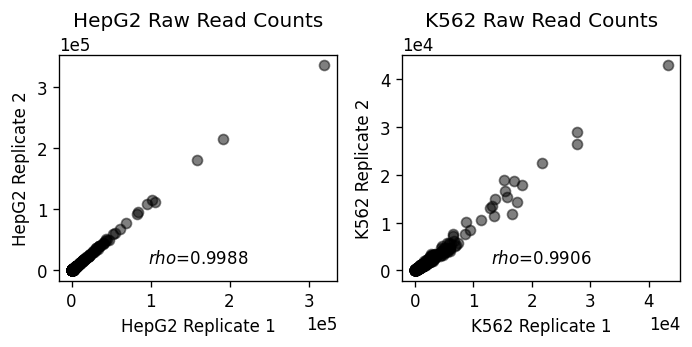

In [12]:
# DHS version

# R1 version

raw_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/wouter_log2fc_df_clean.csv')

HEPG2_REP1_COL = 'cnt_hepg2_r3'
HEPG2_REP2_COL = 'cnt_hepg2_r4'
K562_REP1_COL = 'cnt_k562_r1'
K562_REP2_COL = 'cnt_k562_r2'

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6,3))

# plot HEPG2 REP1 vs REP2 scatterplot
ax1.scatter(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL],color='black',alpha=0.5)
ax1.set_xlabel('HepG2 Replicate 1')
ax1.set_ylabel('HepG2 Replicate 2')
ax1.set_title('HepG2 Raw Read Counts')
# add text annotation of R^2
# r2 = np.corrcoef(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL])[0,1]**2
r2 = spearmanr(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL])[0]
ax1.text(0.5, 0.1, f'$rho$={r2:.4f}', ha='center', va='center', transform=ax1.transAxes)

# plot K562 REP1 vs REP2 scatterplot
ax2.scatter(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL],color='black',alpha=0.5)
ax2.set_xlabel('K562 Replicate 1')
ax2.set_ylabel('K562 Replicate 2')
ax2.set_title('K562 Raw Read Counts')
# add text annotation of R^2
# r2 = np.corrcoef(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL])[0,1]**2
r2 = spearmanr(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL])[0]
ax2.text(0.5, 0.1, f'$rho$={r2:.4f}', ha='center', va='center', transform=ax2.transAxes)

ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


# set tight
plt.tight_layout()

# save figure
plt.savefig(f'{supp_figure_dir}/S1/S1x_raw_read_counts_rep_correlation_dhs.png',dpi=500,bbox_inches='tight')

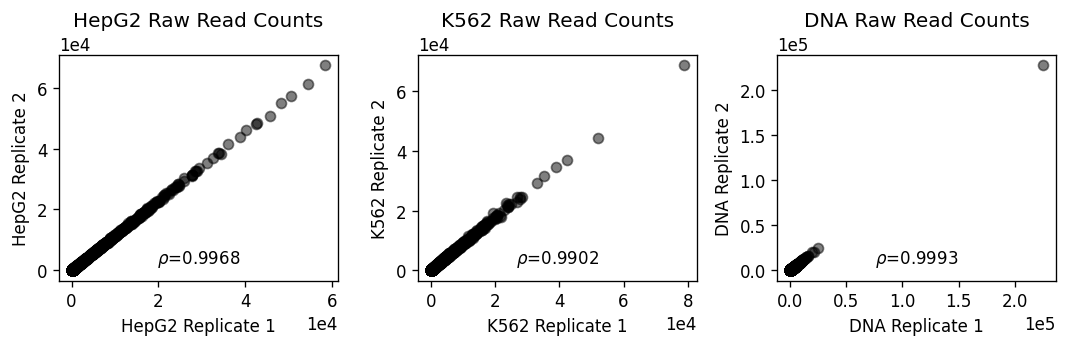

In [10]:
# R2 version

raw_deseq_df = pd.read_csv('illumina_processing/log2fc/log2fc_enhancer.csv')

HEPG2_REP1_COL = 'D3_HepG2_r1'
HEPG2_REP2_COL = 'D3_HepG2_r2'
K562_REP1_COL = 'D3_K562_r1'
K562_REP2_COL = 'D3_K562_r2'
DNA_REP1_COL = 'D3_DNA_r1'
DNA_REP2_COL = 'D3_DNA_r2'

# 1x2 subplot with HEPG2 and K562
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(9,3))

# plot HEPG2 REP1 vs REP2 scatterplot
ax1.scatter(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL],color='black',alpha=0.5)
ax1.set_xlabel('HepG2 Replicate 1')
ax1.set_ylabel('HepG2 Replicate 2')
ax1.set_title('HepG2 Raw Read Counts')
# add text annotation of R^2
# r2 = np.corrcoef(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL])[0,1]**2
r2 = spearmanr(raw_deseq_df[HEPG2_REP1_COL],raw_deseq_df[HEPG2_REP2_COL])[0]
ax1.text(0.5, 0.1, f'$\\rho$={r2:.4f}', ha='center', va='center', transform=ax1.transAxes)

# plot K562 REP1 vs REP2 scatterplot
ax2.scatter(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL],color='black',alpha=0.5)
ax2.set_xlabel('K562 Replicate 1')
ax2.set_ylabel('K562 Replicate 2')
ax2.set_title('K562 Raw Read Counts')
# add text annotation of R^2
# r2 = np.corrcoef(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL])[0,1]**2
r2 = spearmanr(raw_deseq_df[K562_REP1_COL],raw_deseq_df[K562_REP2_COL])[0]
ax2.text(0.5, 0.1, f'$\\rho$={r2:.4f}', ha='center', va='center', transform=ax2.transAxes)

# plot DNA REP1 vs REP2 scatterplot
ax3.scatter(raw_deseq_df[DNA_REP1_COL],raw_deseq_df[DNA_REP2_COL],color='black',alpha=0.5)
ax3.set_xlabel('DNA Replicate 1')
ax3.set_ylabel('DNA Replicate 2')
ax3.set_title('DNA Raw Read Counts')
# add text annotation of R^2
# r2 = np.corrcoef(raw_deseq_df[DNA_REP1_COL],raw_deseq_df[DNA_REP2_COL])[0,1]**2
r2 = spearmanr(raw_deseq_df[DNA_REP1_COL],raw_deseq_df[DNA_REP2_COL])[0]
ax3.text(0.5, 0.1, f'$\\rho$={r2:.4f}', ha='center', va='center', transform=ax3.transAxes)
# set xtick format to exponential
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax3.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
# also for y
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


# set tight
plt.tight_layout()

# save figure
plt.savefig(f'{supp_figure_dir}/S3/S3C_raw_read_counts_rep_correlation.png',dpi=500,bbox_inches='tight')


In [5]:
raw_deseq_df.head()

,Unnamed: 0,D3_HepG2_r1,D3_HepG2_r2,D3_K562_r1,D3_K562_r2,D3_DNA_r1,D3_DNA_r2,baseMean_HepG2_DNA,log2FoldChange_HepG2_DNA,lfcSE_HepG2_DNA,pvalue_HepG2_DNA,padj_HepG2_DNA,baseMean_K562_DNA,log2FoldChange_K562_DNA,lfcSE_K562_DNA,pvalue_K562_DNA,padj_K562_DNA
0,design_1041_ablated_0_0,26,24,30,21,260,268,78.498233,-1.547728,0.290025,7.479304e-08,9.181511e-08,78.498233,-1.229234,0.289130,1.886415e-05,2.211634e-05
1,design_1041_ablated_0_1,76,75,73,58,585,560,190.645701,-1.087861,0.182662,2.312319e-09,2.899099e-09,190.645701,-0.994486,0.188439,1.214127e-07,1.472368e-07
2,design_1041_ablated_0_2,60,67,101,77,908,1024,267.015175,-2.087139,0.186869,3.785417e-29,5.707625e-29,267.015175,-1.306097,0.174046,5.430505e-14,7.152431e-14
3,design_1041_ablated_1_0,112,126,502,445,2418,2554,841.946129,-2.552189,0.116119,2.416285e-107,5.778658e-107,841.946129,-0.262588,0.083384,1.628436e-03,1.835280e-03
4,design_1041_ablated_1_1,216,284,528,518,5768,5987,1530.801817,-2.726794,0.092792,3.971877e-190,1.320583e-189,1530.801817,-1.358110,0.080195,2.166887e-64,4.092251e-64


### S4 Sublibrary boxswarm comparisons ###

In [11]:
s4_fig_dir = f'{supp_figure_dir}/S4'
os.makedirs(s4_fig_dir,exist_ok=True)

# combine sequences from R1 and R2 into the same dataframe

columns = ['sequence_name','cell_type','model_type','design_type',f'{HEPG2_COL}',f'{K562_COL}',f'{H2K_COL}']

d2_analysis_df = d2_deseq_plus_cluster_cnts_df[columns].copy()
d3_analysis_df = d3_seq_df.loc[d3_seq_df['cell_type'].isin(['HEPG2','K562']),columns].copy()

dhs_deseq_df['model_type'] = 'dhs'
dhs_analysis_df  = dhs_deseq_df.loc[dhs_deseq_df['design_type']=='gan',columns].copy()

# add round column to d2_analysis_df and d3_analysis_df
d2_analysis_df['round'] = 'R1'
d3_analysis_df['round'] = 'R2'
dhs_analysis_df['round'] = 'R1-D'

# concatenate d2_analysis_df and d3_analysis_df
analysis_df = pd.concat([d2_analysis_df,dhs_analysis_df,d3_analysis_df])

C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\1552516652.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


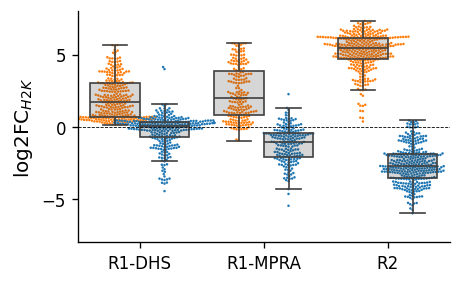

In [29]:
# first plot: R1-DHS vs R1-MPRA (vs R2?)
cur_analysis_df = analysis_df.copy()
cur_analysis_df['plot_category'] = 'Unassigned'

# get all R1-DHS sequences with design_type == gan, should be all dhs designs already but will be explicit here
cur_analysis_df.loc[(cur_analysis_df['round']=='R1-D') & (cur_analysis_df['design_type']=='gan'),'plot_category'] = 'R1-DHS'
# get all R1-MPRA sequences that were designed
r1_model_types = ['wide','ensemble_boot','boot']
r1_design_types = ['fsp','sim_anneal','DENs']
cur_analysis_df.loc[(cur_analysis_df['round']=='R1') & (cur_analysis_df['model_type'].isin(r1_model_types)) & (cur_analysis_df['design_type'].isin(r1_design_types)),'plot_category'] = 'R1-MPRA'

r2_model_types = ['d1_finetuned','d2_dhs']
r2_design_types = ['fsp','fsp_clipped'] # excludes target, minimal
cur_analysis_df.loc[(cur_analysis_df['round']=='R2') & (cur_analysis_df['model_type'].isin(r2_model_types)) & (cur_analysis_df['design_type'].isin(r2_design_types)),'plot_category'] = 'R2'

cur_analysis_df = cur_analysis_df[cur_analysis_df['plot_category']!='Unassigned']

####################

# plot beeswarm and boxplot, with boxplot on top, and jittered beeswarm
palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue'}

order = ['R1-DHS','R1-MPRA','R2']
xtick_labels = ['R1-DHS','R1-MPRA','R2']

fig,ax = plt.subplots(figsize=(4,2.5))

# s = 2.5
s = 1.5

sns.swarmplot(x="plot_category", y=f'{H2K_COL}', hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
                palette=palette,size=s, dodge=True,edgecolor='k',linewidth=0.0,zorder=0,alpha=1)
# set boxplot to be on top of beeswarm plot
sns.boxplot(x="plot_category", y=f'{H2K_COL}', hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
            palette=palette,boxprops={'facecolor':(0.2,0.2,0.2,0.2)},showfliers=False)

# draw horizontal line at 0
ax.axhline(y=0, color='k', linestyle='--',linewidth=0.5)
# set ylim -8 to 8
ax.set_ylim(-8,8)

ax.set_xlabel('')
ax.set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
ax.set_xticklabels(xtick_labels)
# ax.set_title('Strength of Cell Type Specificity by Generator and Cell Type')
# hide legend
ax.legend_.remove()
# ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), ncol=1)

# remove all the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)


# plt.show()

# save figure at high dpi
plt.savefig(f'{s4_fig_dir}/figs4A_boxswarm_dhs_vs_mpra.png',dpi=600,bbox_inches='tight')

C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\3815303732.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


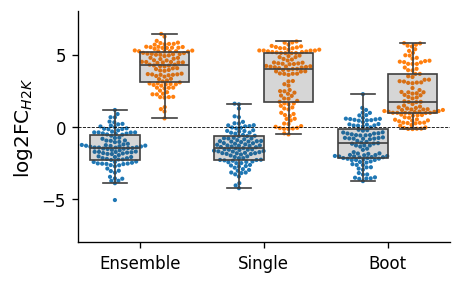

In [28]:
# second plot: R1 model types


cur_analysis_df = analysis_df.copy()
cur_analysis_df['plot_category'] = 'Unassigned'

# Create the super-category column
cur_analysis_df.loc[(analysis_df['round']=='R1') & (cur_analysis_df['design_type']=='DENs') & (cur_analysis_df['model_type']=='ensemble'),'plot_category'] = 'R1 DEN Ensemble'
cur_analysis_df.loc[(analysis_df['round']=='R1') & (cur_analysis_df['design_type']=='DENs') & (cur_analysis_df['model_type']=='single'),'plot_category'] = 'R1 DEN Single'
cur_analysis_df.loc[(analysis_df['round']=='R1') & (cur_analysis_df['design_type']=='DENs') & (cur_analysis_df['model_type']=='boot'),'plot_category'] = 'R1 DEN Boot'
cur_analysis_df = cur_analysis_df[cur_analysis_df['plot_category']!='Unassigned']

####################

# plot beeswarm and boxplot, with boxplot on top, and jittered beeswarm
palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue'}

order = ['R1 DEN Ensemble','R1 DEN Single','R1 DEN Boot']
xtick_labels = ['Ensemble','Single','Boot']

fig,ax = plt.subplots(figsize=(4,2.5))

s = 2.5
# s = 1.5

sns.swarmplot(x="plot_category", y=f'{H2K_COL}', hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
                palette=palette,size=s, dodge=True,edgecolor='k',linewidth=0.0,zorder=0,alpha=1)
# set boxplot to be on top of beeswarm plot
sns.boxplot(x="plot_category", y=f'{H2K_COL}', hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
            palette=palette,boxprops={'facecolor':(0.2,0.2,0.2,0.2)},showfliers=False)

# draw horizontal line at 0
ax.axhline(y=0, color='k', linestyle='--',linewidth=0.5)
# set ylim -8 to 8
ax.set_ylim(-8,8)

ax.set_xlabel('')
ax.set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
ax.set_xticklabels(xtick_labels)
# ax.set_title('Strength of Cell Type Specificity by Generator and Cell Type')
# hide legend
ax.legend_.remove()
# ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), ncol=1)

# remove all the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)


# plt.show()

# save figure at high dpi
plt.savefig(f'{s4_fig_dir}/figs4B_boxswarm_r1_model_types.png',dpi=600,bbox_inches='tight')

C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\3936883095.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


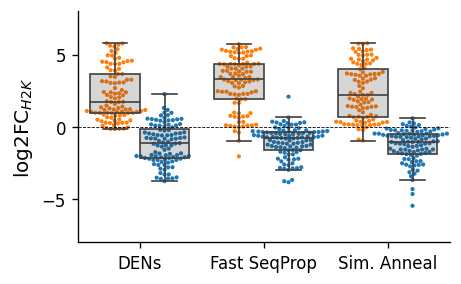

In [30]:
# third plot: R1 design types


cur_analysis_df = analysis_df.copy()
cur_analysis_df['plot_category'] = 'Unassigned'

# Create the super-category column
cur_analysis_df.loc[(analysis_df['round']=='R1') & (cur_analysis_df['design_type']=='DENs') & (cur_analysis_df['model_type']=='boot'),'plot_category'] = 'DENs'
cur_analysis_df.loc[(analysis_df['round']=='R1') & (cur_analysis_df['design_type']=='seqprop') & (cur_analysis_df['model_type']=='boot'),'plot_category'] = 'Fast SeqProp'
cur_analysis_df.loc[(analysis_df['round']=='R1') & (cur_analysis_df['design_type']=='sim_anneal') & (cur_analysis_df['model_type']=='boot'),'plot_category'] = 'Sim. Anneal'
cur_analysis_df = cur_analysis_df[cur_analysis_df['plot_category']!='Unassigned']

####################

# plot beeswarm and boxplot, with boxplot on top, and jittered beeswarm
palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue'}

order = ['DENs','Fast SeqProp','Sim. Anneal']
xtick_labels = ['DENs','Fast SeqProp','Sim. Anneal']

fig,ax = plt.subplots(figsize=(4,2.5))

s = 2.5
# s = 1.5

sns.swarmplot(x="plot_category", y=f'{H2K_COL}', hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
                palette=palette,size=s, dodge=True,edgecolor='k',linewidth=0.0,zorder=0,alpha=1)
# set boxplot to be on top of beeswarm plot
sns.boxplot(x="plot_category", y=f'{H2K_COL}', hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
            palette=palette,boxprops={'facecolor':(0.2,0.2,0.2,0.2)},showfliers=False)

# draw horizontal line at 0
ax.axhline(y=0, color='k', linestyle='--',linewidth=0.5)
# set ylim -8 to 8
ax.set_ylim(-8,8)

ax.set_xlabel('')
ax.set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
ax.set_xticklabels(xtick_labels)
# ax.set_title('Strength of Cell Type Specificity by Generator and Cell Type')
# hide legend
ax.legend_.remove()
# ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), ncol=1)

# remove all the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)


# plt.show()

# save figure at high dpi
plt.savefig(f'{s4_fig_dir}/figs4C_boxswarm_r1_design_types.png',dpi=600,bbox_inches='tight')

C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\245750006.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


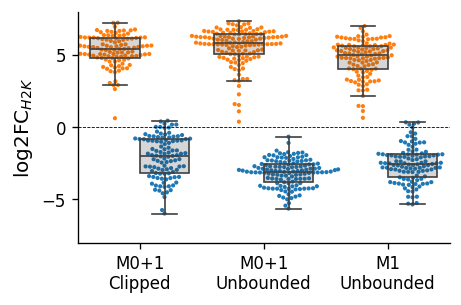

In [26]:
# fourth plot: R2 variations


cur_analysis_df = analysis_df.copy()
cur_analysis_df['plot_category'] = 'Unassigned'

# Create the super-category column
cur_analysis_df.loc[(analysis_df['round']=='R2') & (cur_analysis_df['design_type']=='fsp') & (cur_analysis_df['model_type']=='d1_finetuned'),'plot_category'] = 'M0+1, Unbounded'
cur_analysis_df.loc[(analysis_df['round']=='R2') & (cur_analysis_df['design_type']=='fsp') & (cur_analysis_df['model_type']=='d2_dhs'),'plot_category'] = 'M0+1, Clipped'
cur_analysis_df.loc[(analysis_df['round']=='R2') & (cur_analysis_df['design_type']=='fsp_clipped') & (cur_analysis_df['model_type']=='d1_finetuned'),'plot_category'] = 'M1, Unbounded'
cur_analysis_df = cur_analysis_df[cur_analysis_df['plot_category']!='Unassigned']

####################

# plot beeswarm and boxplot, with boxplot on top, and jittered beeswarm
palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue'}

order = ['M0+1, Clipped','M0+1, Unbounded','M1, Unbounded']
xtick_labels = ['M0+1\nClipped','M0+1\nUnbounded','M1\nUnbounded']

fig,ax = plt.subplots(figsize=(4,2.5))

s = 2.5
# s = 1.5

sns.swarmplot(x="plot_category", y=f'{H2K_COL}', hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
                palette=palette,size=s, dodge=True,edgecolor='k',linewidth=0.0,zorder=0,alpha=1)
# set boxplot to be on top of beeswarm plot
sns.boxplot(x="plot_category", y=f'{H2K_COL}', hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
            palette=palette,boxprops={'facecolor':(0.2,0.2,0.2,0.2)},showfliers=False)

# draw horizontal line at 0
ax.axhline(y=0, color='k', linestyle='--',linewidth=0.5)
# set ylim -8 to 8
ax.set_ylim(-8,8)

ax.set_xlabel('')
ax.set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
ax.set_xticklabels(xtick_labels)
# ax.set_title('Strength of Cell Type Specificity by Generator and Cell Type')
# hide legend
ax.legend_.remove()
# ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), ncol=1)

# remove all the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)


# plt.show()

# save figure at high dpi
plt.savefig(f'{s4_fig_dir}/figs4D_boxswarm_r2_variations.png',dpi=600,bbox_inches='tight')

### Max1/Min1 Analysis ###

In [40]:
design_types = ['fsp_max1','fsp_clipped_max1','fsp_min1','fsp_clipped_min1','NC']
min1_design_types = ['fsp_min1','fsp_clipped_min1','NC']
max1_design_types = ['fsp_max1','fsp_clipped_max1','NC']
model_types = ['d1_finetuned','d2_dhs','D2','shuffled']


analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types)) & 
                                            (d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types))].copy()

# to analysis_df also append the most specific enhancer design for each cell type
# get most specific design for each cell type
model_types = ['d1_finetuned','d2_dhs']
design_types = ['fsp','fsp_clipped','fsp_tgt']
temp_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types)) &
                                        (d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types))].copy()
best_rows = {}
best_rows['HEPG2'] = temp_df[H2K_COL].idxmax()
best_rows['K562'] = temp_df[H2K_COL].idxmin()

# append d3_deseq_plus_cluster_cnts_df.iloc[best_rows['HEPG2']], d3_deseq_plus_cluster_cnts_df.iloc[best_rows['K562']] to analysis_df
analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df.iloc[[best_rows['HEPG2'],best_rows['K562']]]],ignore_index=True,axis=0)
# analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df.iloc[best_rows['K562']]],ignore_index=True,axis=0)
# reset index
analysis_df.reset_index(inplace=True,drop=True)

# change the cell_type of the appended rows to current cell type plus '_max_h2k'
analysis_df.loc[~analysis_df['design_type'].isin(max1_design_types + min1_design_types), 'cell_type'] = 'max spec.'

C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\4179240315.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


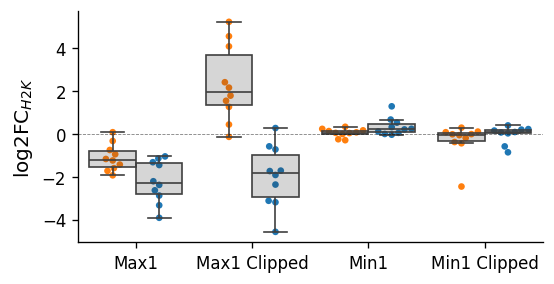

In [33]:
# plot beeswarm and boxplot, with boxplot on top, and jittered beeswarm

cell_types = ['HEPG2','K562']
cur_analysis_df = analysis_df[(analysis_df['model_type']=='d1_finetuned') & (analysis_df['cell_type'].isin(cell_types))].copy()

TARGET_COL = 'model_type'

order = ['fsp_max1','fsp_clipped_max1','fsp_min1','fsp_clipped_min1']
palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue'}

group_cnts = cur_analysis_df.groupby(['model_type','cell_type']).size().reset_index(name='counts')

# xtick_labels = ['DEN','SeqProp','SimAnneal','Motif Repeats','Control']
xtick_labels = ['Max1','Max1 Clipped','Min1','Min1 Clipped']


fig, ax = plt.subplots(figsize=(5, 2.5))
sns.swarmplot(x="design_type", y=H2K_COL, hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
                palette=palette,size=4, dodge=True,edgecolor='k',linewidth=0.0,zorder=0,alpha=1)
# set boxplot to be on top of beeswarm plot
sns.boxplot(x="design_type", y=H2K_COL, hue="cell_type", data=cur_analysis_df, ax=ax, order=order,
            palette=palette,boxprops={'facecolor':(0.2,0.2,0.2,0.2)},showfliers=False)

# draw horizontal line at 0
ax.axhline(y=0, color='k', linestyle='--',linewidth=0.5,alpha=0.5)

ax.set_xlabel('')
ax.set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
ax.set_xticklabels(xtick_labels)
# ax.set_title('Strength of Cell Type Specificity by model_type and Cell Type')
# hide legend
ax.legend_.remove()
# ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), ncol=1)

# draw horizontal line at 0
# ax.axhline(y=0, color='k', linestyle='--',linewidth=1.5,alpha=0.5)

# plot horizontal line at max and min log2FoldChange_H2K_deseq for rows of cur_analysis_df where model_type is control
# ax.axhline(y=h2k_ctrl_max, color='k', linestyle='--',linewidth=0.5,alpha=0.5)
# ax.axhline(y=h2k_ctrl_min, color='k', linestyle='--',linewidth=0.5,alpha=0.5)

# remove all the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)




# add arrows for more H specific, more k SPECIFIC

# print(f'HEPG2 Ctrl max: {h2k_ctrl_max}')
# print(f'K562 Ctrl max: {h2k_ctrl_min}')

# save figure
plt.savefig(f'{supp_figure_dir}/S4/boxswarm_max1_min1.png',dpi=600,bbox_inches='tight')

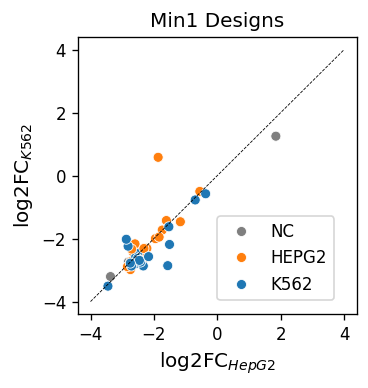

In [41]:
# scatterplot of K562_COL vs H2K_COL

cell_type_palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue', 'max spec.': 'tab:green','NC': 'tab:gray'}
cur_analysis_df = analysis_df[analysis_df['design_type'].isin(min1_design_types)].copy()
plt.figure(figsize=(3,3))
sns.scatterplot(x=HEPG2_COL,y=K562_COL,data=cur_analysis_df,hue='cell_type',palette=cell_type_palette)
# draw slope 1 line
plt.plot([-4,4],[-4,4],color='k',linestyle='--',linewidth=0.5)
# move legend outside and below plot
# move legend to bottom left corner
plt.legend(loc='lower left', bbox_to_anchor=(0.5, 0.05), borderaxespad=0.)
plt.xlabel('log2FC$_{HepG2}$',fontsize=AXIS_FSIZE)
plt.ylabel('log2FC$_{K562}$',fontsize=AXIS_FSIZE)
plt.title('Min1 Designs')

# save figure
plt.savefig(f'{supp_figure_dir}/S4/min1_k_vs_h_scatter.png',dpi=600,bbox_inches='tight')
plt.show()

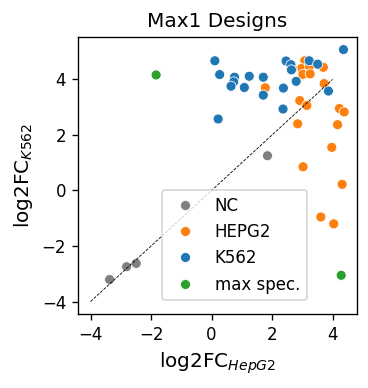

In [43]:
# scatterplot of K562_COL vs H2K_COL

cur_analysis_df = analysis_df[analysis_df['design_type'].isin(max1_design_types + ['NC','fsp','fsp_clipped'])].copy()
plt.figure(figsize=(3,3))
sns.scatterplot(x=HEPG2_COL,y=K562_COL,data=cur_analysis_df,hue='cell_type',palette=cell_type_palette)
# draw slope 1 line
plt.plot([-4,4],[-4,4],color='k',linestyle='--',linewidth=0.5)
# move legend to bottom left corner
plt.legend(loc='lower left', bbox_to_anchor=(0.3, 0.05), borderaxespad=0.)
plt.xlabel('log2FC$_{HepG2}$',fontsize=AXIS_FSIZE)
plt.ylabel('log2FC$_{K562}$',fontsize=AXIS_FSIZE)
plt.title('Max1 Designs')

# save figure
plt.savefig(f'{supp_figure_dir}/S4/max1_k_vs_h_scatter.png',dpi=600,bbox_inches='tight')
plt.show()

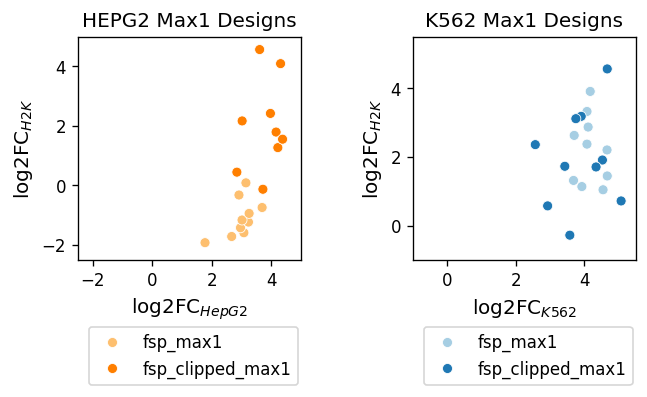

In [44]:
# for HEPG2, plot H2K_COL vs HEPG2_COL, and on second subplot plot -H2K_COL vs K562_COL

# make subplots
fig, ax = plt.subplots(1,2,figsize=(6,2.5))

# plot H2K_COL vs HEPG2_COL
hepg2_palette = {'fsp_max1':sns.color_palette("Paired")[6],'fsp_clipped_max1':sns.color_palette("Paired")[7]}
cur_analysis_df = analysis_df[(analysis_df['cell_type']=='HEPG2') & (analysis_df['design_type'].isin(max1_design_types))].copy()
sns.scatterplot(x=HEPG2_COL,y=H2K_COL,data=cur_analysis_df,ax=ax[0],hue='design_type',palette=hepg2_palette)
# draw slope 1 line
# ax[0].plot([-4,4],[-4,4],color='k',linestyle='--',linewidth=0.5)
# move legend outside and below plot
ax[0].legend(bbox_to_anchor=(0.05, -.3), loc=2, borderaxespad=0.)
ax[0].set_xlabel('log2FC$_{HepG2}$',fontsize=AXIS_FSIZE)
ax[0].set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
ax[0].set_title('HEPG2 Max1 Designs')
# set x and ylims to be the same
ax[0].set_xlim(-2.5,5)
ax[0].set_ylim(-2.5,5)
# make plot square
ax[0].set_aspect('equal')

# plot -H2K_COL vs K562_COL
k562_palette = {'fsp_max1':sns.color_palette("Paired")[0],'fsp_clipped_max1':sns.color_palette("Paired")[1]}
cur_analysis_df = analysis_df[(analysis_df['cell_type']=='K562') & (analysis_df['design_type'].isin(max1_design_types))].copy()
cur_analysis_df['K2H_COL'] = -cur_analysis_df[H2K_COL]
sns.scatterplot(x=K562_COL,y='K2H_COL',data=cur_analysis_df,ax=ax[1],hue='design_type',palette=k562_palette)
# draw slope 1 line
# ax[1].plot([-4,4],[-4,4],color='k',linestyle='--',linewidth=0.5)
# move legend outside and below plot
ax[1].legend(bbox_to_anchor=(0.05, -.3), loc=2, borderaxespad=0.)
ax[1].set_xlabel('log2FC$_{K562}$',fontsize=AXIS_FSIZE)
ax[1].set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
ax[1].set_title('K562 Max1 Designs')


# set x and ylims to be the same
ax[1].set_xlim(-1,5.5)
ax[1].set_ylim(-1,5.5)

# make plot square
ax[1].set_aspect('equal')

# increase horizontal space between subplots
plt.subplots_adjust(wspace=0.5)

# save as supp fig
plt.savefig(f'{supp_figure_dir}/S4/d3_specificity_vs_strength_max1_designs_scatter.png',dpi=600,bbox_inches='tight')

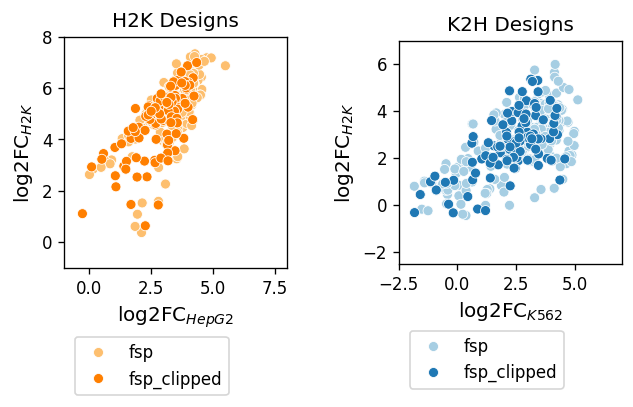

In [45]:
# make the same plot but for non-max1 designs

# for HEPG2, plot H2K_COL vs HEPG2_COL, and on second subplot plot -H2K_COL vs K562_COL

design_types = ['fsp','fsp_clipped']
model_types = ['d1_finetuned','d2_dhs']

analysis_df = d3_seq_df[(d3_seq_df['design_type'].isin(design_types)) & (d3_seq_df['model_type'].isin(model_types))].copy()

# make subplots
fig, ax = plt.subplots(1,2,figsize=(6,2.5))

# plot H2K_COL vs HEPG2_COL
hepg2_palette = {'fsp':sns.color_palette("Paired")[6],'fsp_clipped':sns.color_palette("Paired")[7]}
cur_analysis_df = analysis_df[(analysis_df['cell_type']=='HEPG2')].copy()
sns.scatterplot(x=HEPG2_COL,y=H2K_COL,data=cur_analysis_df,ax=ax[0],hue='design_type',palette=hepg2_palette)
# draw slope 1 line
# ax[0].plot([-4,4],[-4,4],color='k',linestyle='--',linewidth=0.5)
# move legend outside and below plot
ax[0].legend(bbox_to_anchor=(0.05, -.3), loc=2, borderaxespad=0.)
ax[0].set_xlabel('log2FC$_{HepG2}$',fontsize=AXIS_FSIZE)
ax[0].set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
ax[0].set_title('H2K Designs')

# set x and ylims to be the same
ax[0].set_xlim(-1,8)
ax[0].set_ylim(-1,8)
# make plot square
ax[1].set_aspect('equal')

# plot -H2K_COL vs K562_COL
k562_palette = {'fsp':sns.color_palette("Paired")[0],'fsp_clipped':sns.color_palette("Paired")[1]}
cur_analysis_df = analysis_df[(analysis_df['cell_type']=='K562')].copy()
cur_analysis_df['K2H_COL'] = -cur_analysis_df[H2K_COL]
sns.scatterplot(x=K562_COL,y='K2H_COL',data=cur_analysis_df,ax=ax[1],hue='design_type',palette=k562_palette)
# draw slope 1 line
# ax[1].plot([-4,4],[-4,4],color='k',linestyle='--',linewidth=0.5)
# move legend outside and below plot
ax[1].legend(bbox_to_anchor=(0.05, -.3), loc=2, borderaxespad=0.)
ax[1].set_xlabel('log2FC$_{K562}$',fontsize=AXIS_FSIZE)
ax[1].set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
ax[1].set_title('K2H Designs')

# set x and ylims to be the same
ax[1].set_xlim(-2.5,7)
ax[1].set_ylim(-2.5,7)
# make plot square
ax[1].set_aspect('equal')

# increase horizontal space between subplots
plt.subplots_adjust(wspace=0.5)

# save figure
# plt.tight_layout()
# save as supp fig
plt.savefig(f'{supp_figure_dir}/S4/d3_specificity_vs_strength_h2k_designs_scatter.png',dpi=600,bbox_inches='tight')

In [66]:
design_types = ['fsp_max1','fsp_clipped_max1','fsp_min1','fsp_clipped_min1','NC']
min1_design_types = ['fsp_min1','fsp_clipped_min1','NC']
max1_design_types = ['fsp_max1','fsp_clipped_max1','NC']
model_types = ['d1_finetuned','d2_dhs','D2','shuffled']


analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types)) & 
                                            (d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types))].copy()

# to analysis_df also append the most specific enhancer design for each cell type
# get most specific design for each cell type
model_types = ['d1_finetuned','d2_dhs']
design_types = ['fsp','fsp_clipped','fsp_tgt']
temp_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types)) &
                                        (d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types))].copy()
best_rows = {}
best_rows['HEPG2'] = temp_df[H2K_COL].idxmax()
best_rows['K562'] = temp_df[H2K_COL].idxmin()

# append d3_deseq_plus_cluster_cnts_df.iloc[best_rows['HEPG2']], d3_deseq_plus_cluster_cnts_df.iloc[best_rows['K562']] to analysis_df
analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df.iloc[[best_rows['HEPG2'],best_rows['K562']]]],ignore_index=True,axis=0)
# analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df.iloc[best_rows['K562']]],ignore_index=True,axis=0)
# reset index
analysis_df.reset_index(inplace=True,drop=True)

# change the cell_type of the appended rows to current cell type plus '_max_h2k'
analysis_df.loc[~analysis_df['design_type'].isin(max1_design_types + min1_design_types), 'cell_type'] = 'max_h2k'

C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\1370240218.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blue_cm = cm.get_cmap('Blues')
C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\1370240218.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orange_cm = cm.get_cmap('Oranges')


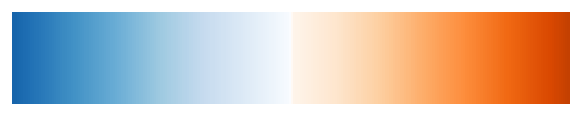

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

# Get the colormaps
blue_cm = cm.get_cmap('Blues')
orange_cm = cm.get_cmap('Oranges')

# Create color arrays for blue and orange colormaps
blues = blue_cm(np.linspace(0.0, 0.8, 256))[::-1]  # Reverse the blue colors
oranges = orange_cm(np.linspace(0.0, 0.8, 256))

# Combine the colormaps with white at the center
whites = np.ones((2, 4))  # Two whites in the center
colors = np.vstack((blues, whites, oranges))

# Create a custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list('CustomMap', colors)

# Test the custom colormap
gradient = np.linspace(-1, 1, 512).reshape(1, -1)
fig, ax = plt.subplots(figsize=(6, 1))
ax.imshow(gradient, aspect='auto', cmap=custom_cmap)
plt.axis('off')
plt.show()


C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\1555591958.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blue_cm = cm.get_cmap('Blues')
C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\1555591958.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orange_cm = cm.get_cmap('Oranges')


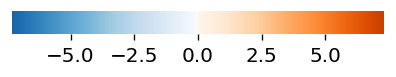

In [73]:
# merge the blues_trunc_cm and oranges_trunc_cm colormaps
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import numpy as np

# get the blue and orange colormaps
blue_cm = cm.get_cmap('Blues')
orange_cm = cm.get_cmap('Oranges')

# get the colors from the blue and orange colormaps
blues = bluesBig(np.linspace(0.0, 0.8, 256))[::-1]
oranges = orangesBig(np.linspace(0.0, 0.8, 256))

# combine the blue and orange colors
colors = np.vstack((blues,oranges))

# create a new colormap from the combined colors
combined_cm = LinearSegmentedColormap.from_list('combined_cm', colors)

# # plot the combined colormap
# plt.imshow([range(256)], cmap=combined_cm)

# create colorbar from div_cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True) with vmin=-.75,vmax=.75, horizontal

# create colorbar
fig, ax = plt.subplots(figsize=(4,0.25))
# cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
norm = plt.Normalize(-7.3,7.3)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=combined_cm,norm=norm,orientation='horizontal')
cb1.set_label('')
# remove black edges
cb1.outline.set_edgecolor('none')
# set xticks to -.75 to .75 by .25
# cb1.set_ticks(np.arange(-.75,.76,.25))
# move xticks above colorbar
cb1.ax.xaxis.set_ticks_position('bottom')
# set tick fontsize
cb1.ax.tick_params(labelsize=12)
# save figure
plt.savefig(f'{supp_figure_dir}/S5/h2k_colorbar.png',dpi=600,bbox_inches='tight',transparent=True)

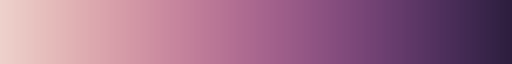

In [48]:
cell_strength_cm = sns.cubehelix_palette(as_cmap=True)

C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\3367256067.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluesBig = matplotlib.cm.get_cmap('Blues', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\3367256067.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orangesBig = matplotlib.cm.get_cmap('Oranges', 512)


14


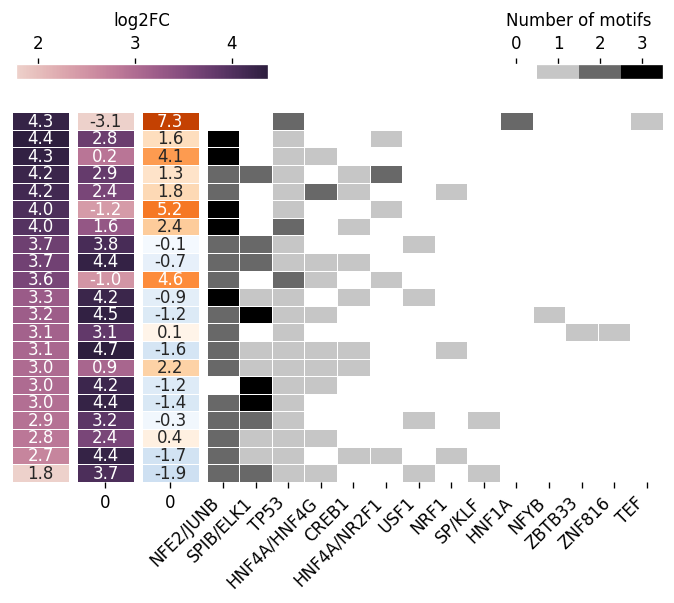

In [72]:
## Okay, I am going to create the cluster heatmap for these designs
# I will plot one cell type at a time, and plot all 20 max3 designs
# there will be 3 columns to the left of the cluster map: HEPG2_COL, K562_COL, H2K_COL
# and the sequences will be sorted by desending specificity, or cell type-strength? probably specificity
# okay, pulling in code from the flank redesign....

cur_cell_type = 'HEPG2'
cur_analysis_df = analysis_df[(analysis_df['cell_type']==cur_cell_type) & (analysis_df['design_type'].isin(max1_design_types))].copy()
cur_analysis_df = cur_analysis_df.sort_values(by=HEPG2_COL,ascending=(cur_cell_type=='K562'))
cur_analysis_df = pd.concat([d3_deseq_plus_cluster_cnts_df.iloc[[best_rows[cur_cell_type]]],cur_analysis_df],ignore_index=True,axis=0)
# reset index
cur_analysis_df.reset_index(inplace=True,drop=True)

### Okay I think this should be d1_ft, d2_dhs, and d2_meas, exclude all the dhs64 and dhs62 designs but keep everything else ###

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
# create reverse version of blues_trunc_cm
blues_trunc_cm_r = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.8, 0.15, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))




# drop all cluster columns that sum to 0

cluster_cols = [col for col in cur_analysis_df.columns if 'cluster_' in col]
cur_analysis_df.drop(columns=[col for col in cluster_cols if cur_analysis_df[col].sum()==0], inplace=True)
cluster_cols = np.array([col for col in cur_analysis_df.columns if 'cluster_' in col])
print(len(cluster_cols))

## here##########################################################################################

vmin = cur_analysis_df[cluster_cols].min().min()
# vmax = cur_analysis_df[cluster_cols].max().max()
vmax = 3

# make the cmap for heatmap
n_colors = int(vmax-vmin+1)
colors = plt.cm.Greys(np.linspace(0, 1, n_colors))
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_colors)

# plot np.array(cur_analysis_df[hepg2_clusters]) as heatmap with rows corresponding to sequences and columns the motifs
n_clusters_to_plot = len(cluster_cols)
cluster_sort_inds = np.argsort(np.array(cur_analysis_df[cluster_cols]).sum(axis=0))[::-1][:n_clusters_to_plot]


# set figure width based on number of clusters, using a constant width_per_cluster
width_per_cluster = 5
fig_width = width_per_cluster * n_clusters_to_plot

# 4 hepg2 motifs, 5 k562 motifs so axis ratios should be 4:5
# 8 HEPG2 motifs, 5 K562 motifs so axis ratios should be 8:5
# fig, (ax0, ax3, ax2, ax3) = plt.subplots(1,4,figsize=(8,2),sharey=True,gridspec_kw={'width_ratios': [1,8,1,10]})

# make 2 side by side subplots
fig, (ax0, ax1,ax2,ax3) = plt.subplots(1,4,figsize=(7,4),sharey=True,gridspec_kw={'width_ratios': [1,1,1,8]})
# plot hepg2 heatmap
sns.heatmap(np.array(cur_analysis_df[cluster_cols])[:,cluster_sort_inds],xticklabels=cluster_cols[cluster_sort_inds],cmap=cmap,cbar=False,ax=ax3,
            edgecolor='white',linewidth=0.5)
# remove yticks
ax3.set_yticks([])
# ax3.set_title(f'HEPG2')
ax3.set_xticklabels([cluster_name_dict[cluster] for cluster in cluster_cols[cluster_sort_inds]],fontsize=TEXT_FSIZE,rotation=45,ha='right')
# plot hepg2 log2(H2K):
# replace this with combined_cm after debug
# minimum of HEPG2_COL and K562_COL
cell_strength_vmin = np.min([cur_analysis_df[HEPG2_COL].min(),cur_analysis_df[K562_COL].min()])
# maximum of HEPG2_COL and K562_COL
cell_strength_vmax = np.max([cur_analysis_df[HEPG2_COL].max(),cur_analysis_df[K562_COL].max()])

h2k_vmax = 7.3
h2k_vmin = -7.3


sns.heatmap(cur_analysis_df[H2K_COL].values.reshape(-1, 1), cmap=combined_cm, cbar=False, ax=ax2,annot=True,
            fmt='.1f',edgecolor='white',linewidth=0.5,vmin=h2k_vmin,vmax=h2k_vmax)
# plot HEPG2_COL
sns.heatmap(cur_analysis_df[HEPG2_COL].values.reshape(-1, 1), cmap=cell_strength_cm, cbar=False, ax=ax0,annot=True,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=hepg2_vmin,vmax=hepg2_vmax
# plot K562_COL
sns.heatmap(cur_analysis_df[K562_COL].values.reshape(-1, 1), cmap=cell_strength_cm, cbar=False, ax=ax1,annot=True,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=k562_vmin,vmax=k562_vmax


# set overall figure title
# fig.suptitle(f'Motifs in top {int(percentile*100)}% of sequences\n')

# add colorbar above the subplots
# cbar_ax = fig.add_axes([0.3, -0.175, 0.4, 0.03])
from matplotlib.ticker import MaxNLocator
cbar_ax = fig.add_axes([0.7, 0.95, 0.2, 0.03])

boundaries = np.linspace(vmin - 0.5, vmax + 0.5, n_colors + 1)
ticks = np.arange(vmin, vmax + 1)

cb = fig.colorbar(ax3.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=boundaries,ticks=ticks,format="%d")
# plt.colorbar(ticks=ticks, boundaries=boundaries, format="%d", orientation='vertical')
# cb = fig.colorbar(ax3.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=np.arange(0,vmax+1,1),ticks=np.arange(0,vmax+1,1))
cbar_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cbar_ax.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax.set_title('Number of motifs',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax.set_xlabel('')
cbar_ax.set_ylabel('')
# set cb outline to white
cb.outline.set_edgecolor('white')
# set cb ticks to ticks
cb.set_ticks(ticks=ticks,labels=np.arange(vmin,vmax+1).astype(int))

# cb = fig.colorbar(ax3.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=boundaries,ticks=ticks,format="%d")
# cbar_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# cbar_ax.xaxis.tick_top()
# # move title of cbar_ax to above the colorbar
# cbar_ax.set_title('Number of motifs',fontsize=TEXT_FSIZE,y=3)
# # remove x and y labels
# cbar_ax.set_xlabel('')
# cbar_ax.set_ylabel('')
# # set cb outline to white
# cb.outline.set_edgecolor('white')
# cb.set_ticks(ticks=ticks,labels=np.arange(vmin,vmax+1).astype(int))



# add colorbar for H2K for HEPG2 seqs to the left of cbar_ax
cbar_ax_h2k = fig.add_axes([0.13, 0.95, 0.3, 0.03])
# cbar_ax_h2k = fig.add_axes([0.13, 0.95, 0.2, 0.03])
cb_hepg2 = fig.colorbar(ax0.collections[0], cax=cbar_ax_h2k,orientation='horizontal',label='log2FC',shrink=0.01,drawedges=False)
cbar_ax_h2k.xaxis.set_major_locator(MaxNLocator(integer=True))
# move ticks above colorbar
cbar_ax_h2k.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax_h2k.set_title('log2FC',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax_h2k.set_xlabel('')
cbar_ax_h2k.set_ylabel('')
# set colorbar outline to white
cb_hepg2.outline.set_edgecolor('white')


# remove yticks from ax0
ax0.set_yticks([])
ax0.set_xticks([])
# decrease space between ax0 and ax3
plt.subplots_adjust(wspace=0.05)

# plot every other xtick label on cbar_ax_hepg2_h2k
# for i,tick in enumerate(cbar_ax_h2k.get_xticklabels()):
#     if i%2==0:
#         tick.set_visible(False)



# save figure
plt.savefig(f'{supp_figure_dir}/S5/hepg2_max1_motif_cluster_heatmap.png',dpi=600,bbox_inches='tight')

C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\3167622749.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluesBig = matplotlib.cm.get_cmap('Blues', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_14392\3167622749.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orangesBig = matplotlib.cm.get_cmap('Oranges', 512)


9


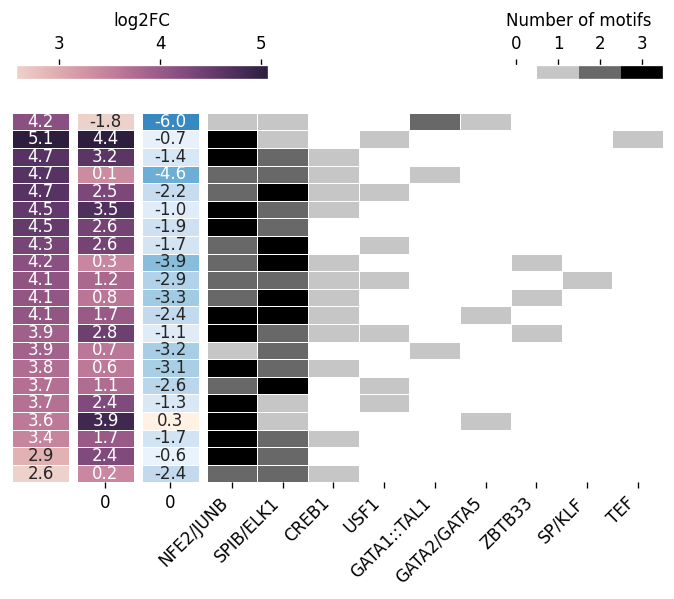

In [71]:
## Okay, I am going to create the cluster heatmap for these designs
# I will plot one cell type at a time, and plot all 20 max3 designs
# there will be 3 columns to the left of the cluster map: HEPG2_COL, K562_COL, H2K_COL
# and the sequences will be sorted by desending specificity, or cell type-strength? probably specificity
# okay, pulling in code from the flank redesign....

cur_cell_type = 'K562'
cur_analysis_df = analysis_df[(analysis_df['cell_type']==cur_cell_type) & (analysis_df['design_type'].isin(max1_design_types))].copy()
cur_analysis_df = cur_analysis_df.sort_values(by=K562_COL,ascending=False)
cur_analysis_df = pd.concat([d3_deseq_plus_cluster_cnts_df.iloc[[best_rows[cur_cell_type]]],cur_analysis_df],ignore_index=True,axis=0)
# reset index
cur_analysis_df.reset_index(inplace=True,drop=True)

### Okay I think this should be d1_ft, d2_dhs, and d2_meas, exclude all the dhs64 and dhs62 designs but keep everything else ###

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
# create reverse version of blues_trunc_cm
blues_trunc_cm_r = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.8, 0.15, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))


# drop all cluster columns that sum to 0

cluster_cols = [col for col in cur_analysis_df.columns if 'cluster_' in col]
cur_analysis_df.drop(columns=[col for col in cluster_cols if cur_analysis_df[col].sum()==0], inplace=True)
cluster_cols = np.array([col for col in cur_analysis_df.columns if 'cluster_' in col])
print(len(cluster_cols))

## here##########################################################################################

vmin = cur_analysis_df[cluster_cols].min().min()
# vmax = cur_analysis_df[cluster_cols].max().max()
vmax = 3

# make the cmap for heatmap
n_colors = int(vmax-vmin+1)
colors = plt.cm.Greys(np.linspace(0, 1, n_colors))
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_colors)

# plot np.array(cur_analysis_df[hepg2_clusters]) as heatmap with rows corresponding to sequences and columns the motifs
n_clusters_to_plot = len(cluster_cols)
cluster_sort_inds = np.argsort(np.array(cur_analysis_df[cluster_cols]).sum(axis=0))[::-1][:n_clusters_to_plot]


# set figure width based on number of clusters, using a constant width_per_cluster
width_per_cluster = 5
fig_width = width_per_cluster * n_clusters_to_plot

# 4 hepg2 motifs, 5 k562 motifs so axis ratios should be 4:5
# 8 HEPG2 motifs, 5 K562 motifs so axis ratios should be 8:5
# fig, (ax0, ax3, ax2, ax3) = plt.subplots(1,4,figsize=(8,2),sharey=True,gridspec_kw={'width_ratios': [1,8,1,10]})

# make 2 side by side subplots
fig, (ax0, ax1,ax2,ax3) = plt.subplots(1,4,figsize=(7,4),sharey=True,gridspec_kw={'width_ratios': [1,1,1,8]})
# plot hepg2 heatmap
sns.heatmap(np.array(cur_analysis_df[cluster_cols])[:,cluster_sort_inds],xticklabels=cluster_cols[cluster_sort_inds],cmap=cmap,cbar=False,ax=ax3,
            edgecolor='white',linewidth=0.5)
# remove yticks
ax3.set_yticks([])
# ax3.set_title(f'HEPG2')
ax3.set_xticklabels([cluster_name_dict[cluster] for cluster in cluster_cols[cluster_sort_inds]],fontsize=TEXT_FSIZE,rotation=45,ha='right')
# plot hepg2 log2(H2K):
# replace this with combined_cm after debug
# minimum of HEPG2_COL and K562_COL
cell_strength_vmin = np.min([cur_analysis_df[HEPG2_COL].min(),cur_analysis_df[K562_COL].min()])
# maximum of HEPG2_COL and K562_COL
cell_strength_vmax = np.max([cur_analysis_df[HEPG2_COL].max(),cur_analysis_df[K562_COL].max()])


sns.heatmap(cur_analysis_df[H2K_COL].values.reshape(-1, 1), cmap=combined_cm, cbar=False, ax=ax2,annot=True,
            fmt='.1f',edgecolor='white',linewidth=0.5,vmin=h2k_vmin,vmax=h2k_vmax)
# plot HEPG2_COL
sns.heatmap(cur_analysis_df[HEPG2_COL].values.reshape(-1, 1), cmap=cell_strength_cm, cbar=False, ax=ax1,annot=True,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=hepg2_vmin,vmax=hepg2_vmax
# plot K562_COL
sns.heatmap(cur_analysis_df[K562_COL].values.reshape(-1, 1), cmap=cell_strength_cm, cbar=False, ax=ax0,annot=True,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=k562_vmin,vmax=k562_vmax


# set overall figure title
# fig.suptitle(f'Motifs in top {int(percentile*100)}% of sequences\n')

# add colorbar above the subplots
# cbar_ax = fig.add_axes([0.3, -0.175, 0.4, 0.03])
from matplotlib.ticker import MaxNLocator
cbar_ax = fig.add_axes([0.7, 0.95, 0.2, 0.03])

boundaries = np.linspace(vmin - 0.5, vmax + 0.5, n_colors + 1)
ticks = np.arange(vmin, vmax + 1)

cb = fig.colorbar(ax3.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=boundaries,ticks=ticks,format="%d")
# plt.colorbar(ticks=ticks, boundaries=boundaries, format="%d", orientation='vertical')
# cb = fig.colorbar(ax3.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=np.arange(0,vmax+1,1),ticks=np.arange(0,vmax+1,1))
cbar_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cbar_ax.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax.set_title('Number of motifs',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax.set_xlabel('')
cbar_ax.set_ylabel('')
# set cb outline to white
cb.outline.set_edgecolor('white')
# set cb ticks to ticks
cb.set_ticks(ticks=ticks,labels=np.arange(vmin,vmax+1).astype(int))

# cb = fig.colorbar(ax3.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=boundaries,ticks=ticks,format="%d")
# cbar_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# cbar_ax.xaxis.tick_top()
# # move title of cbar_ax to above the colorbar
# cbar_ax.set_title('Number of motifs',fontsize=TEXT_FSIZE,y=3)
# # remove x and y labels
# cbar_ax.set_xlabel('')
# cbar_ax.set_ylabel('')
# # set cb outline to white
# cb.outline.set_edgecolor('white')
# cb.set_ticks(ticks=ticks,labels=np.arange(vmin,vmax+1).astype(int))



# add colorbar for H2K for HEPG2 seqs to the left of cbar_ax
cbar_ax_h2k = fig.add_axes([0.13, 0.95, 0.3, 0.03])
# cbar_ax_h2k = fig.add_axes([0.13, 0.95, 0.2, 0.03])
cb_hepg2 = fig.colorbar(ax0.collections[0], cax=cbar_ax_h2k,orientation='horizontal',label='log2FC',shrink=0.01,drawedges=False)
cbar_ax_h2k.xaxis.set_major_locator(MaxNLocator(integer=True))
# move ticks above colorbar
cbar_ax_h2k.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax_h2k.set_title('log2FC',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax_h2k.set_xlabel('')
cbar_ax_h2k.set_ylabel('')
# set colorbar outline to white
cb_hepg2.outline.set_edgecolor('white')


# remove yticks from ax0
ax0.set_yticks([])
ax0.set_xticks([])
# decrease space between ax0 and ax3
plt.subplots_adjust(wspace=0.05)

# plot every other xtick label on cbar_ax_hepg2_h2k
# for i,tick in enumerate(cbar_ax_h2k.get_xticklabels()):
#     if i%2==0:
#         tick.set_visible(False)



# save figure
plt.savefig(f'{supp_figure_dir}/S5/k562_max1_motif_cluster_heatmap.png',dpi=600,bbox_inches='tight')

### Motif diversity analysis ###

In [18]:
### Attempt motif diversity analysis ###
analysis_df = d3_deseq_plus_cluster_cnts_df.copy()
analysis_df['cluster_2_4'] = analysis_df['cluster_2'] + analysis_df['cluster_4']
analysis_df['n_unique_clusters_no_27'] = analysis_df['n_unique_clusters'] - (analysis_df['cluster_27']>0).astype(int)
analysis_df['n_motifs_no_27'] = analysis_df['n_motifs'] - analysis_df['cluster_27']
# ugh can also analyze by highest multiplicity boooo #
clusters = [col for col in analysis_df.columns if 'cluster_' in col]
# remove cluster_27 from clusters
clusters.remove('cluster_27')
analysis_df['max_multiplicity'] = analysis_df[clusters].max(axis=1)
analysis_df['max_multiplicity_thresh'] = analysis_df['max_multiplicity'].apply(lambda x: 4 if x>4 else x)

---------------------------------------------
Testing motif_diversity = 1 vs 2 across motif_density = 2-6
N=2, 56 vs 110
	slope=-0.126, intercept=3.918, r_value=-0.030, p_value=6.984e-01, std_err=0.325
N=3, 26 vs 135
	slope=-0.860, intercept=4.675, r_value=-0.150, p_value=5.691e-02, std_err=0.448
N=4, 8 vs 57
	slope=-0.256, intercept=4.652, r_value=-0.045, p_value=7.199e-01, std_err=0.712
N=5, 1 vs 11
	slope=3.958, intercept=-3.288, r_value=0.720, p_value=8.223e-03, std_err=1.205
N=6, 1 vs 3
	slope=3.435, intercept=-2.963, r_value=0.667, p_value=3.332e-01, std_err=2.715
Meta Slope: -0.161+-0.241 (SE)
Meta Int:   3.878
Two-sided p: 1.498e+00
95% CI: [-0.63320541  0.31034439]
---------------------------------------------

---------------------------------------------
Testing motif_diversity = 2 vs 3 across motif_density = 3-6
N=3, 135 vs 95
	slope=1.142, intercept=0.670, r_value=0.268, p_value=3.700e-05, std_err=0.271
N=4, 57 vs 168
	slope=0.131, intercept=3.876, r_value=0.032, p_value=6

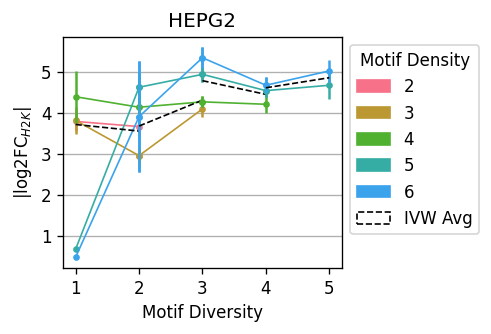

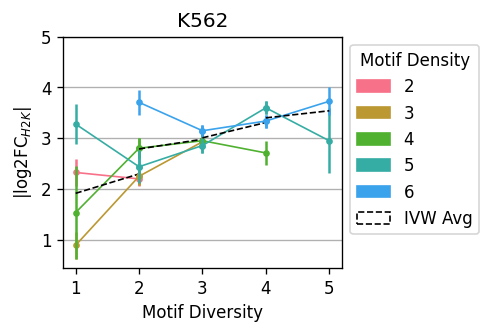

In [19]:
# well okay let's just do some general analysis of heterotypic vs homotypic enhancers, both with and without considering cluster 27

# analysis_df['n_motifs'].value_counts().sort_index()

# hmm could also just exclude seqs with 7+ motifs?
# thresh = 6
# analysis_df['n_motifs_no_27_thresh'] = analysis_df[motif_density_column].apply(lambda x: x if x <= thresh else thresh)

#  let's just try something for now

# okay, so I can try combining slopes across all strata as the first, crudest analysis
# alternatively, I can try combining slopes across strata only for single steps, i.e. 1->2, 2->3, etc. This will reduce sample size but be more correct.
#   at this point, though, would the stratified wilcoxon ranksum make more sense? meh probably, but I don't have code for that analysis and really don't want
#   to try to figure that out, but it might make more sense to do that rather than assume a constant linear trend
#   or for each step I can do stratified linear slope :(

# for n in range(2,7):
#     temp_df = analysis_df[analysis_df[motif_density_column]==n]
#     print(temp_df['n_unique_clusters'].value_counts().sort_index())

### Okay time to start doing things! ###
from scipy.stats import linregress
from scipy.stats import norm

def calc_stratified_ols(std_err_vec,slope_vec,intercept_vec):
    # precision weighted average of the slopes in slope_vec
    std_err_vec = np.array(std_err_vec)

    precisions = 1/std_err_vec**2
    w = precisions/np.sum(precisions)
    se = np.sqrt(1/np.sum(1/(np.array(std_err_vec)**2)))
    # alt_se = np.sqrt(np.sum((w**2)*(std_err_vec**2)))
    m = np.sum(slope_vec*w)
    b = np.sum(intercept_vec*w)

    print(f'Meta Slope: {m:.3f}+-{se:.3f} (SE)')
    print(f'Meta Int:   {b:.3f}')

    # this is (maybe) inverse-variance weighted average causal effect <- or this is fixed-effects meta-analysis

    # Now get 95% CI for m
    from scipy.stats import norm

    # inverse cdf of normal distribution, effectively the z-score
    def qnorm(p):
        return norm.ppf(p) # ppf is inverse cdf, loc=0, scale=1 as defaults

    qnorm(0.975) # 95% CI
    np.array((-1,1))*qnorm(0.975)*se + m # hmm

    # and finally get the p-value
    z = m/se
    p = 1 - norm.cdf(z) # area to right of z in normal distribution
    # print(f'One-sided p: {p:.3e}')
    print(f'Two-sided p: {2*p:.3e}')

    # import qnorm function
    from scipy.stats import norm

    # norm.ppf is inverse cdf of normal distribution, effectively the z-score, equivalent to qnorm with loc=0, scale=1 as defaults
    ci = np.array((-1,1))*norm.ppf(0.975)*se + m
    print(f'95% CI: {np.array((-1,1))*norm.ppf(0.975)*se + m}') # 95% CI

    return m,se,b

# also, let's try visualize this in a plot...for each stratum, for each step plot the mean log2FoldChange_H2K_deseq and the line between them (with error bars)

motif_diversity_max = 5

for cell_type in ['HEPG2','K562']:
    cur_analysis_df = analysis_df[analysis_df['cell_type']==cell_type].copy()
    # create figure
    fig,ax = plt.subplots(figsize=(3,2.5))
    strata_color_palette = sns.color_palette("husl",n_colors=6)

    # okay if I include cluster_27 nothing ends up significant
    # motif_diversity_column = 'n_unique_clusters_no_27'
    # motif_density_column = 'n_motifs_no_27'
    motif_diversity_column = 'n_unique_clusters'
    motif_density_column = 'n_motifs'

    # threshold motif_diversity_column to be at most 5
    cur_analysis_df[motif_diversity_column] = cur_analysis_df[motif_diversity_column].apply(lambda x: x if x <= motif_diversity_max else motif_diversity_max)

    # test 1-4 (1->2, 2->3, 3->4, 4->5), if try to do 5->6 don't have enough examples
    for test_step_base in np.arange(1,5):
        # test_step_base = 1 # will test step from test_step_base to test_step_base+1
        motif_density_strata = np.arange(test_step_base+1,7) # need motif_density_strata to begin at test_step_base+1
        slope_vec = []
        std_err_vec = []
        intercept_vec = []
        print('---------------------------------------------')
        print(f'Testing motif_diversity = {test_step_base} vs {test_step_base+1} across motif_density = {motif_density_strata[0]}-{motif_density_strata[-1]}')

        for idx,stratum in enumerate(motif_density_strata):

            # get rows with n_motifs_no_27 = stratum
            stratum_df = cur_analysis_df.loc[cur_analysis_df[motif_density_column]==stratum].copy()

            # get rows with n_unique_clusters = test_step_base, test_step_base+1
            base_df = stratum_df.loc[(stratum_df[motif_diversity_column]==test_step_base)].copy()
            base_plus1_df = stratum_df.loc[(stratum_df[motif_diversity_column]==test_step_base+1)].copy()

            # if either base_df or base_plus1_df is empty, skip
            if base_df.shape[0] == 0 or base_plus1_df.shape[0] == 0:
                continue

            print(f'N={stratum}, {base_df.shape[0]} vs {base_plus1_df.shape[0]}')

            test_df = pd.concat([base_df,base_plus1_df])

            linreg_out = linregress(x=test_df[motif_diversity_column],y=test_df[H2K_COL].abs())
            slope, intercept, r_value, p_value, std_err = linreg_out
            print(f'\tslope={slope:.3f}, intercept={intercept:.3f}, r_value={r_value:.3f}, p_value={p_value:.3e}, std_err={std_err:.3f}')
            slope_vec.append(slope)
            std_err_vec.append(std_err)
            intercept_vec.append(intercept)

            # plot line between means of base_df and base_plus1_df, with error bars
            # get mean log2FoldChange_H2K_deseq for base_df and base_plus1_df
            base_mean = base_df[H2K_COL].abs().mean()
            base_plus1_mean = base_plus1_df[H2K_COL].abs().mean()
            # get standard error of mean for base_df and base_plus1_df
            base_sem = base_df[H2K_COL].abs().sem()
            base_plus1_sem = base_plus1_df[H2K_COL].abs().sem()
            # plot
            ax.plot([test_step_base,test_step_base+1],[base_mean,base_plus1_mean],'-',lw=1,color=strata_color_palette[stratum-2])
            ax.plot([test_step_base,test_step_base+1],[base_mean,base_plus1_mean],'.',lw=1,color=strata_color_palette[stratum-2])
            ax.errorbar([test_step_base,test_step_base+1],[base_mean,base_plus1_mean],yerr=[base_sem,base_plus1_sem],fmt='none',color=strata_color_palette[stratum-2])



        m,se,b = calc_stratified_ols(std_err_vec,slope_vec,intercept_vec)
        # plot line with slope m and intercept b between test_step_base and test_step_base+1
        x = np.array([test_step_base,test_step_base+1])
        y = m*x + b
        ax.plot(x,y,'--',lw=1,color='k')

        print('---------------------------------------------\n')

    # add a legend with the strata colors
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color=c,label=f'{stratum}') for c,stratum in zip(strata_color_palette,np.arange(2,7))]
    # append one more patch, a dashed black line with label 'Meta'
    patches.append(mpatches.Patch(color='k',label='IVW Avg',ls='--',fill=False))
    ax.legend(handles=patches,loc='upper left',bbox_to_anchor=(1,1),title='Motif Density')
    # make it dashed not solid

    # label axis
    ax.set_xlabel('Motif Diversity')
    ax.set_ylabel('|log2FC$_{H2K}$|')
    # show only whole integer xticks
    ax.set_xticks(np.arange(1,6))
    # set ylim to be 0.5 to 4.5 by 0.5 increments
    # ax.set_ylim(0.5,4.5)
    # set yticks to be 1-5
    ax.set_yticks(np.arange(1,6))
    # add horizontal grid lines
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    # add title
    # ax.set_title('Association between stepwise increase in\n motif diversity and enhancer specificity')
    ax.set_title(f'{cell_type}')


    # okay, and now let's add the version where I test only 1 overall slope per stratum, not per step

    motif_density_strata = np.arange(2,7) # need motif_density_strata to begin at test_step_base+1
    slope_vec = []
    std_err_vec = []
    intercept_vec = []

    print('---------------------------------------------')
    print('Calculating one slope per stratum rather than stepwise slopes')
    for stratum in motif_density_strata:

        # get rows with n_motifs_no_27 = stratum
        test_df = cur_analysis_df.loc[cur_analysis_df[motif_density_column]==stratum].copy()

        print(f'motif_density={stratum}')

        linreg_out = linregress(x=test_df[motif_diversity_column],y=test_df[H2K_COL].abs())
        slope, intercept, r_value, p_value, std_err = linreg_out
        print(f'\tslope={slope:.3f}, intercept={intercept:.3f}, r_value={r_value:.3f}, p_value={p_value:.3e}, std_err={std_err:.3f}')
        slope_vec.append(slope)
        std_err_vec.append(std_err)
        intercept_vec.append(intercept)
    calc_stratified_ols(std_err_vec,slope_vec,intercept_vec)

    # save figure
    # plt.savefig(f'{supp_fig_dir}/S3/S3D_d3_motif_diversity_analysis_{cell_type}.png',dpi=500,bbox_inches='tight')
